# Should change Tkf below

In [1]:
import importlib
import time
import os
import pickle
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy import integrate
from scipy import interpolate

# Should change Tkf below

In [2]:
from multi_loc import covariance, assimilate, utilities

/home/travisharty/anaconda3/envs/loc/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


In [3]:
%matplotlib inline

In [4]:
def imshow(X, title=None, vmin=None, vmax=None, cmap=None):
    plt.figure()
    im = plt.imshow(X, vmin=vmin, vmax=vmax, cmap=cmap)
    plt.colorbar(im)
    plt.title(title)

In [12]:
tune_name = 'coarse_obs_R'

save_dir = 'RK_tune'

home = os.path.expanduser('~')
save_dir = os.path.join(
    home,
    'Documents/python_code/multi_loc/notebooks/',
    save_dir)
    
this_path = os.path.join(save_dir, 'Z_GT.npy')
Zgt = np.load(this_path)

this_path = os.path.join(save_dir, 'Z0_ens.npy')
Z0ens = np.load(this_path)

this_path = os.path.join(save_dir, 't_gt.npy')
t_gt = np.load(this_path)


this_path = os.path.join(save_dir, 'run_vars.pkl')
with open(this_path, mode='rb') as f:
    run_vars = pickle.load(f)

In [13]:
for key, value in run_vars.items():
    print(key + ' = ' + str(value))
    exec(key + '=value')

Nz = 960
K = 32
I = 12
F = 15.0
b = 10.0
c = 2.5
alpha = 0.12414383561643835
beta = 0.013746194824961947
coarse = 8
Nez = 20
Nex = 500
dt_rk = 0.004166666666666667
dt_lr = 0.1
dt_gt = 0.0020833333333333333
Tic = 24.0
Tlr = 4000
Tgt = 250


# Should change Tkf below

In [14]:
tune_dir = os.path.join(save_dir, tune_name)
if not os.path.exists(tune_dir):
    os.mkdir(tune_dir)

dt_trial_rk = 0.005/8
dt_kf = 0.05
dt_save = None
Tkf = Tgt/5     ######## Change this (I forgot) #######
Tspin_index = 500
Tspin = dt_kf * Tspin_index

alpha_range = np.array([0, 0.04, 0.08, 0.12, 0.16], dtype='float')
loc_range = np.array([1, 2, 3, 4, 5, 6], dtype='float')


everyH = 2
Hz = np.eye(Nz)[::everyH]
Ny = Hz.shape[0]

R_sd = 2
rho0 = 0.08
[R_cor] = covariance.generate_circulant(
    Nz, dx=1/Nz, rho0=rho0,
    correlation_fun=covariance.fft_sqd_exp_1d,
    return_Corr=True, return_eig=False)
# I_weight = 0.5
# R_cor = I_weight * np.eye(Nz) + (1 - I_weight) * R_cor
Rz = R_sd**2 * R_cor
Rz = Rz[::everyH, ::everyH]




fine_obs_dict = {'dt_trial_rk': dt_trial_rk,
                 'dt_kf': dt_kf,
                 'dt_save': dt_save,
                 'Tkf': Tkf,
                 'Tspin': Tspin,
                 'alpha_range': alpha_range,
                 'loc_range': loc_range,
                 'R_sd': R_sd,
                 'everyH': everyH,
                 'Hz': Hz,
                 'Rz': Rz}

this_path = os.path.join(tune_dir, 'KF_dict.pkl')
with open(this_path, mode='wb') as f:
    pickle.dump(fine_obs_dict, f)

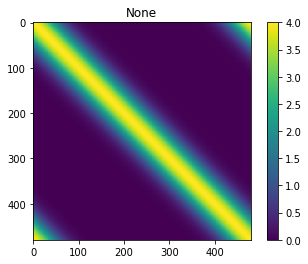

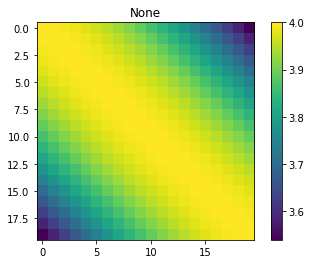

In [15]:
imshow(Rz, vmin=0)
imshow(Rz[:20, :20])

In [16]:
Nobs = int(Tkf/dt_kf) + 1
t_kf = np.linspace(0, Tkf, Nobs)

Ngt = int(Tgt/dt_gt) + 1
t_gt = np.linspace(0, Tgt, Ngt)
index_Tkf = int(Tkf/dt_gt) + 1

every_t = int(dt_kf/dt_gt)

if not np.allclose(t_kf, t_gt[0:index_Tkf:every_t]):
    print('They do not match')

In [17]:
Zloc = np.arange(Nz)

Zgt_ts = xr.DataArray(Zgt[:, 0:index_Tkf:every_t].copy(),
                      dims=('loc', 'time'),
                      coords={'loc': Zloc,
                              'time': t_kf})
Zobs_ts = Zgt[::everyH, 0:index_Tkf:every_t].copy()
Zobs_ts += np.random.multivariate_normal(np.zeros(Ny), Rz, Zobs_ts.shape[1]).T
Zobs_ts = xr.DataArray(Zobs_ts,
                       dims=('loc', 'time'),
                       coords={'loc': Zloc[::everyH],
                               'time': t_kf})
this_path = os.path.join(tune_dir, 'Zobs_ts.nc')
Zobs_ts.to_netcdf(this_path)
del Zgt

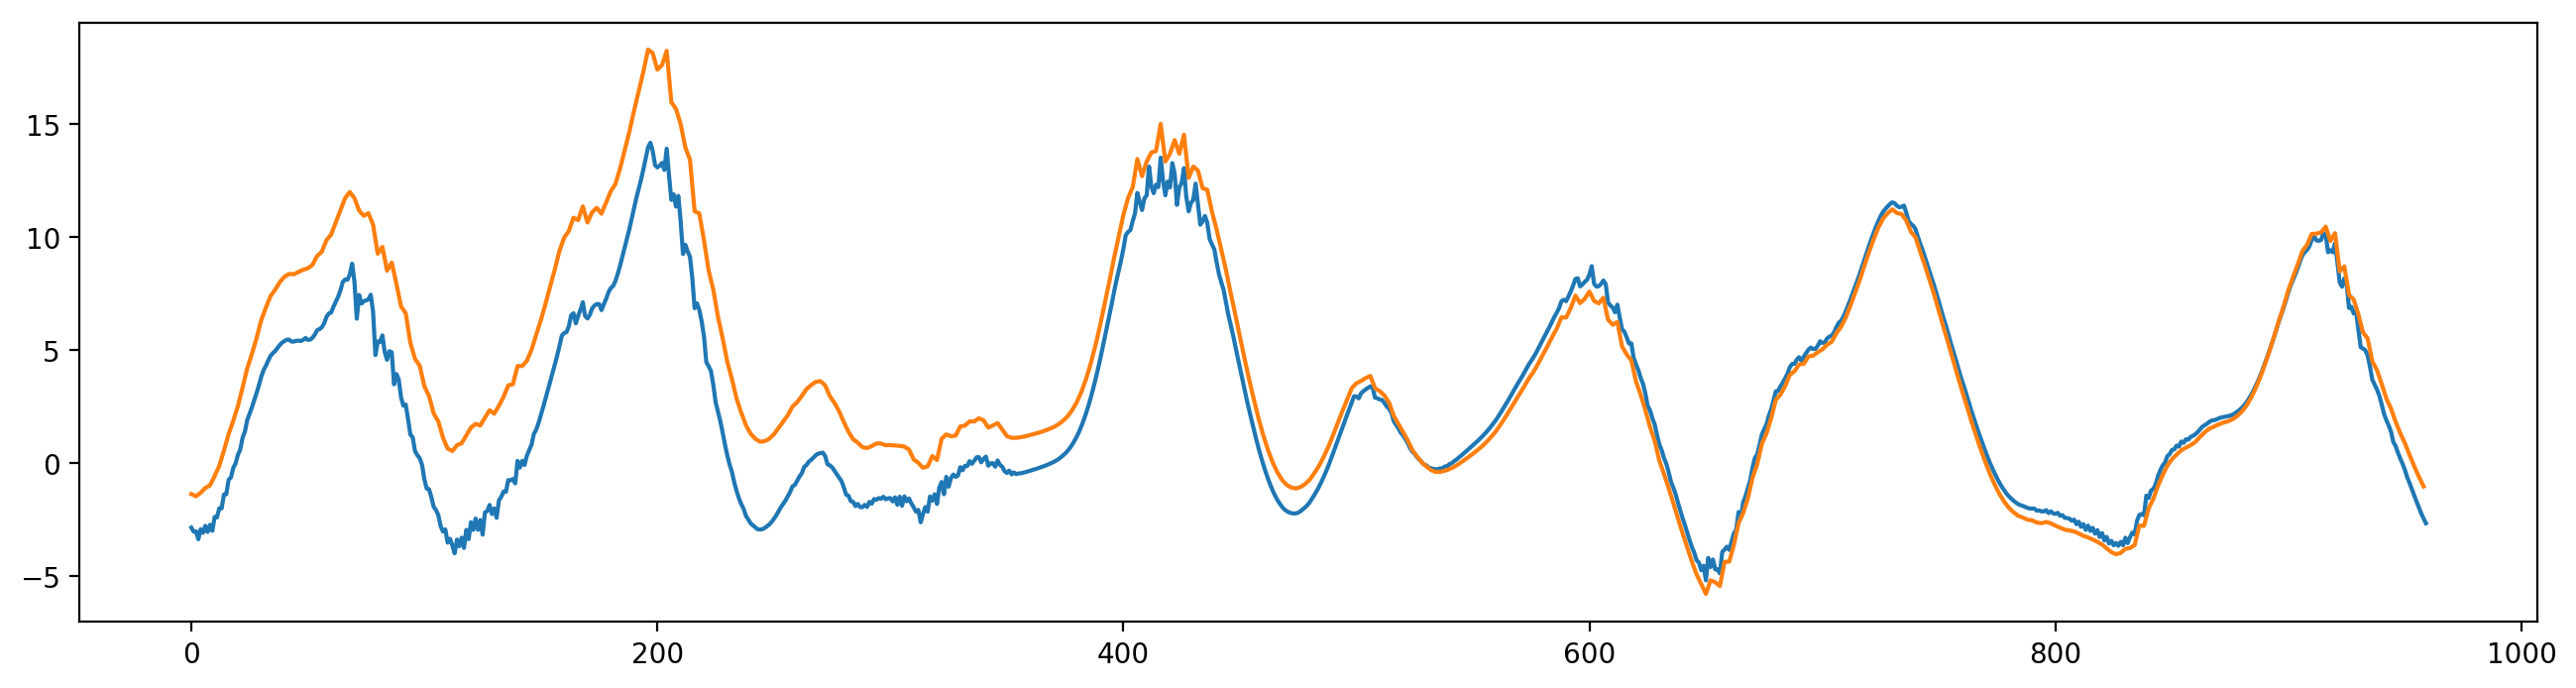

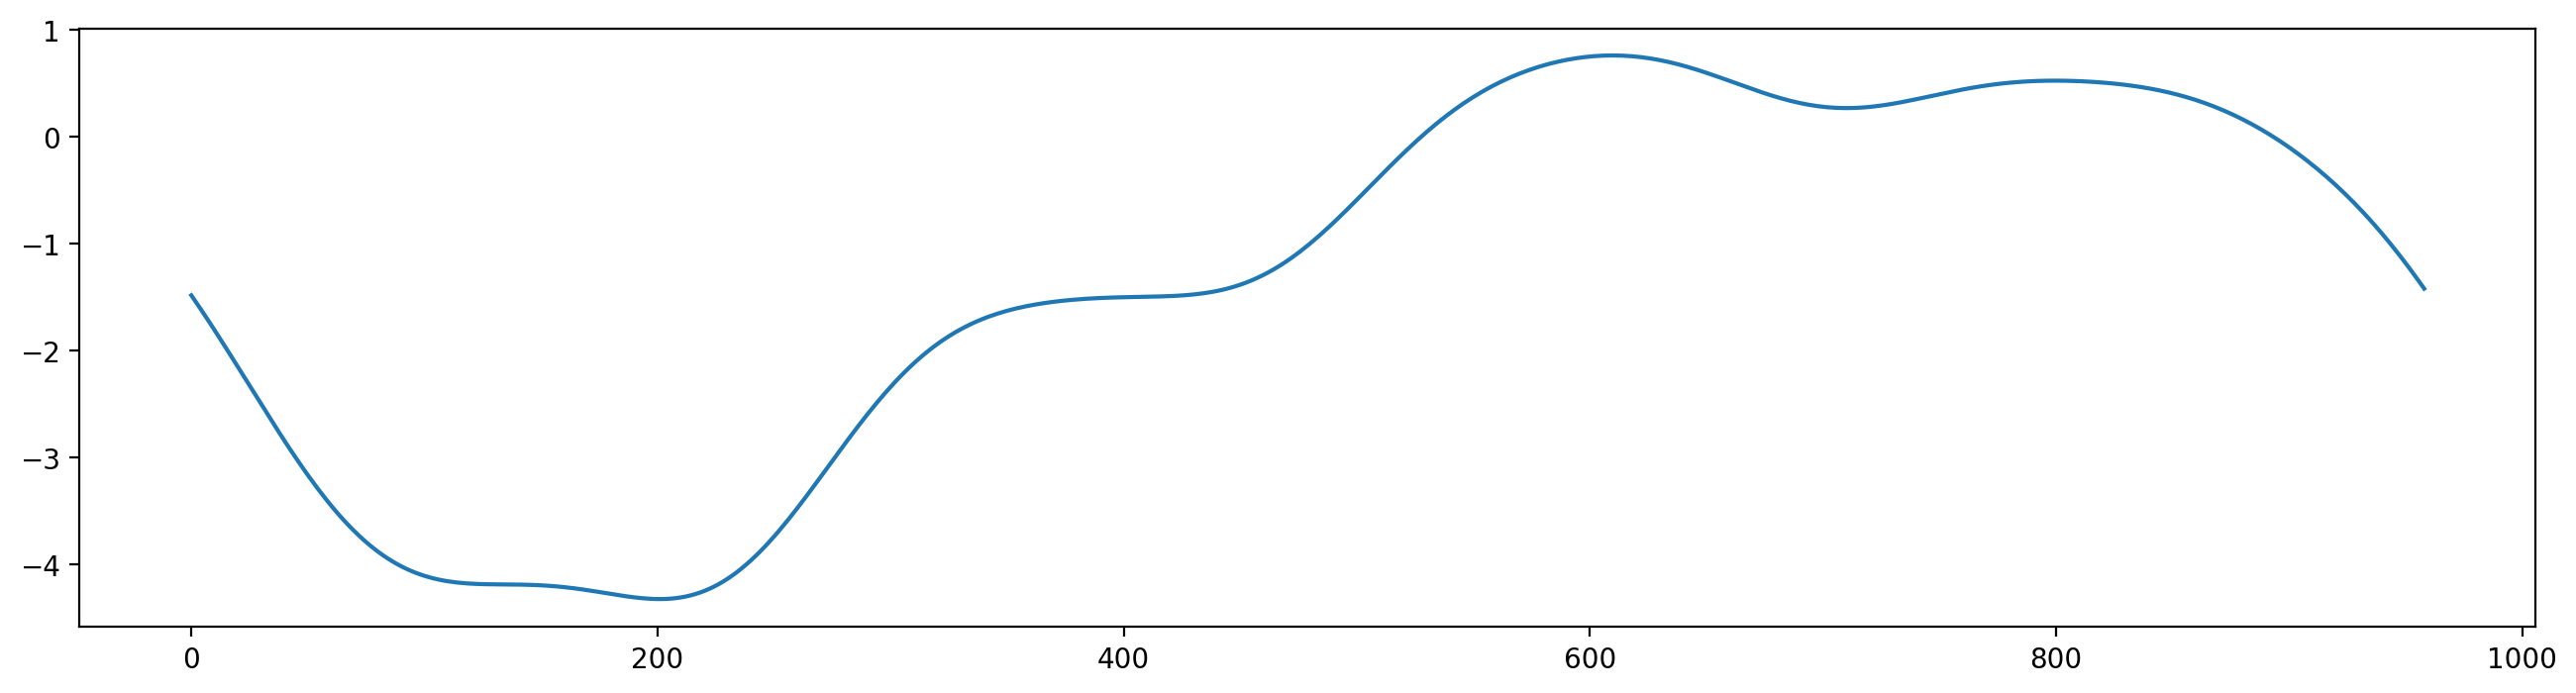

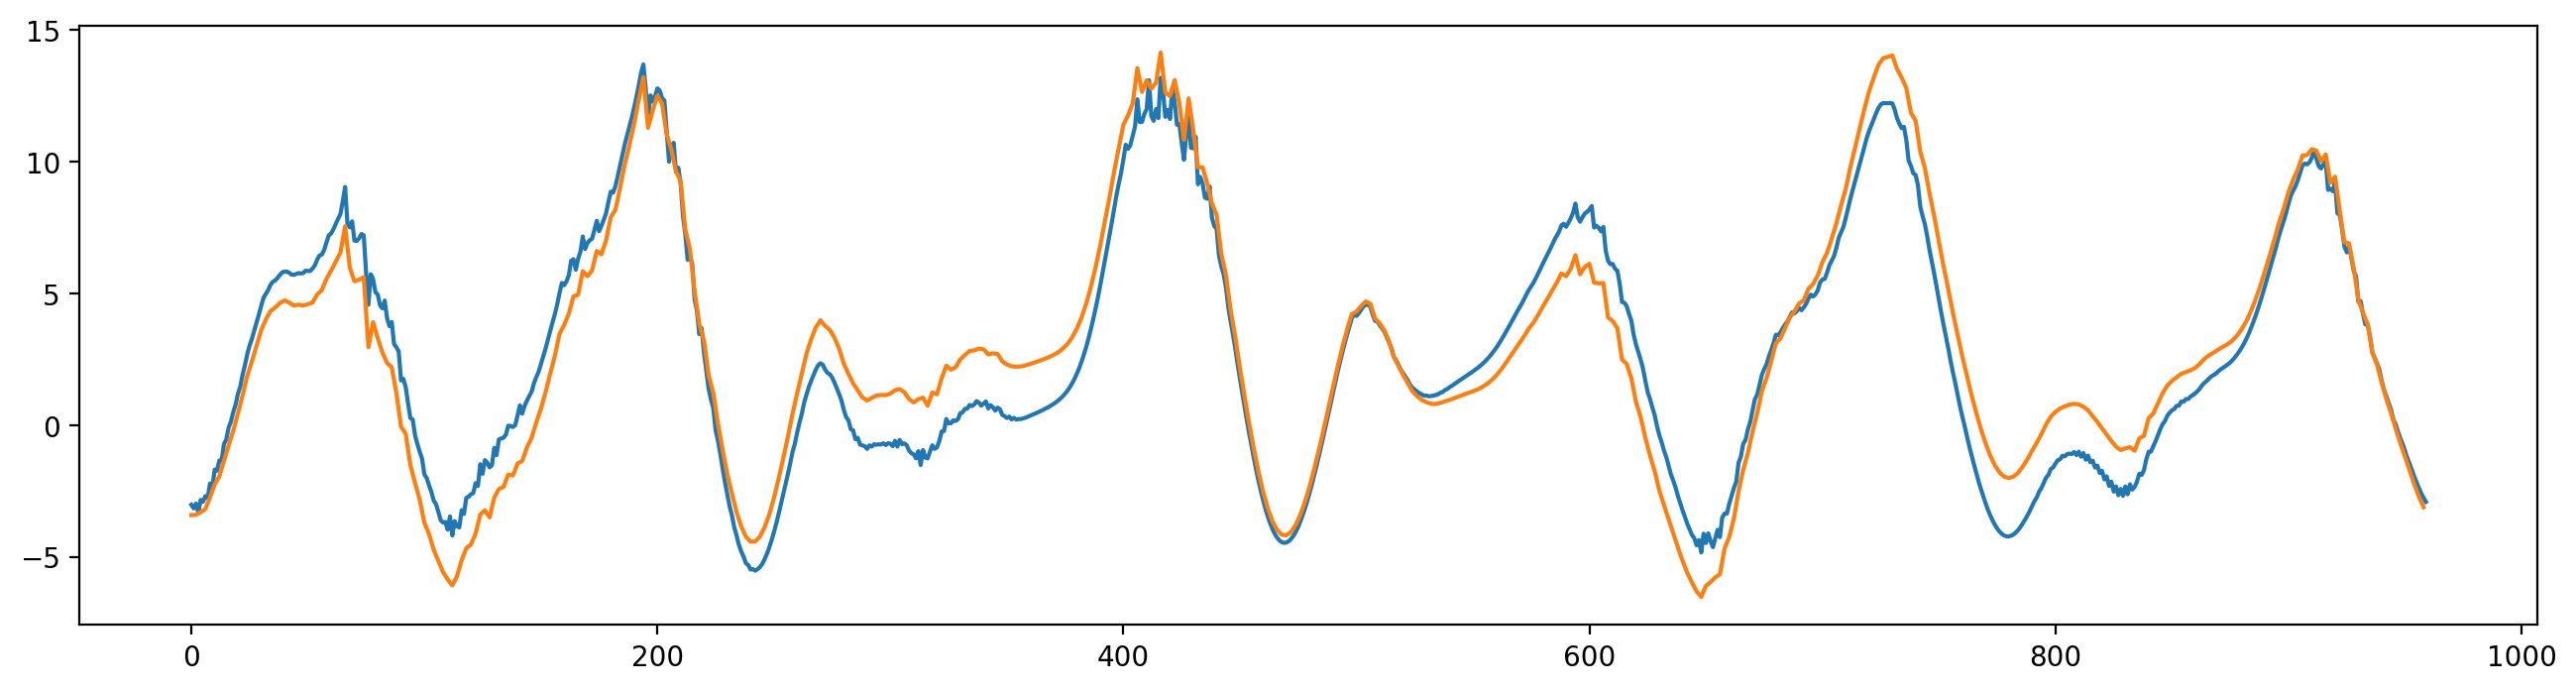

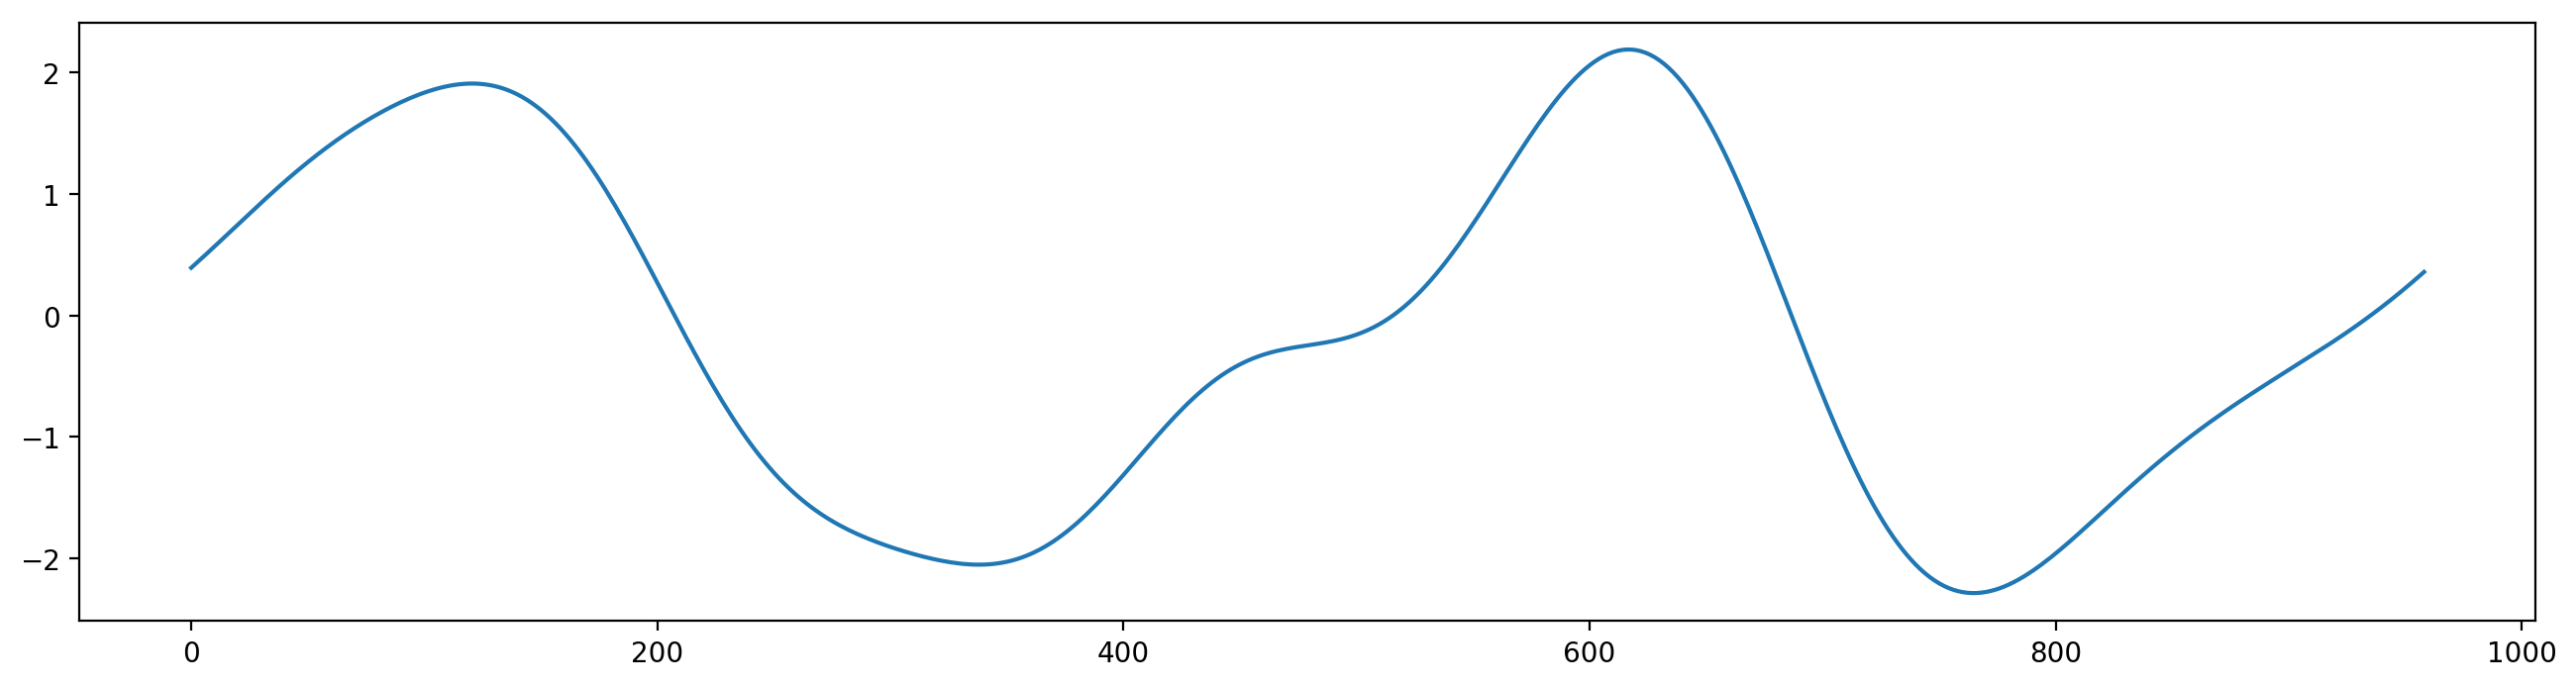

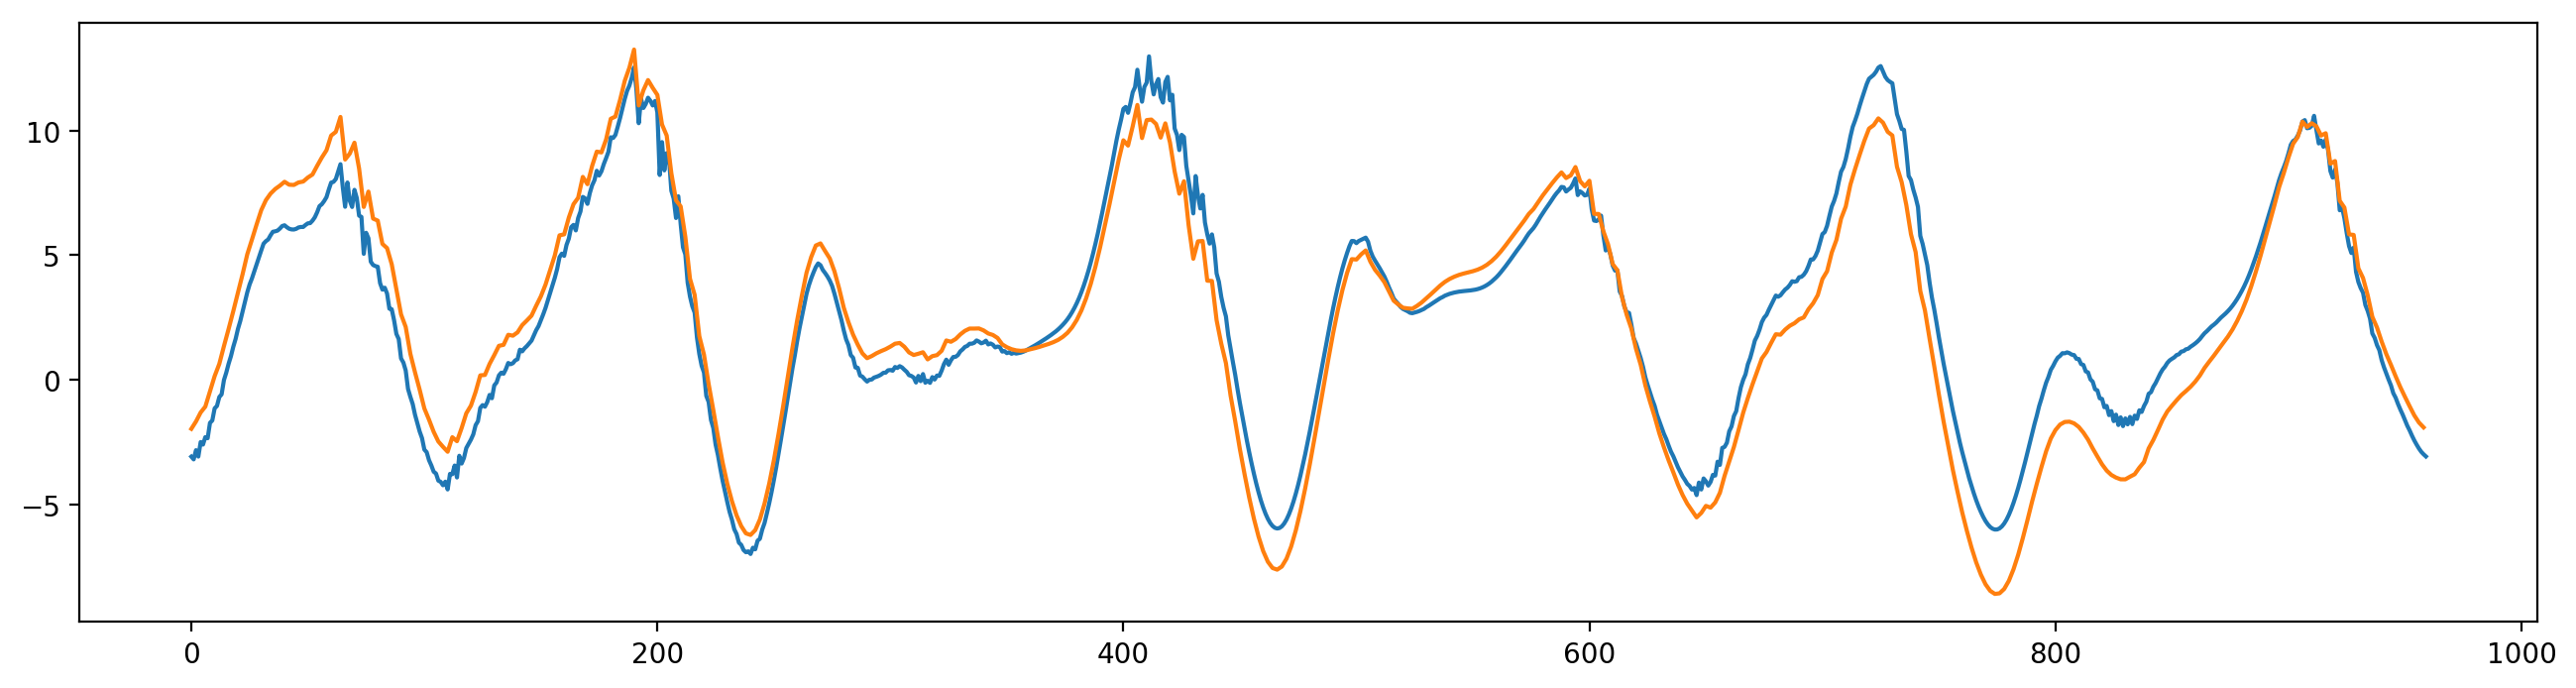

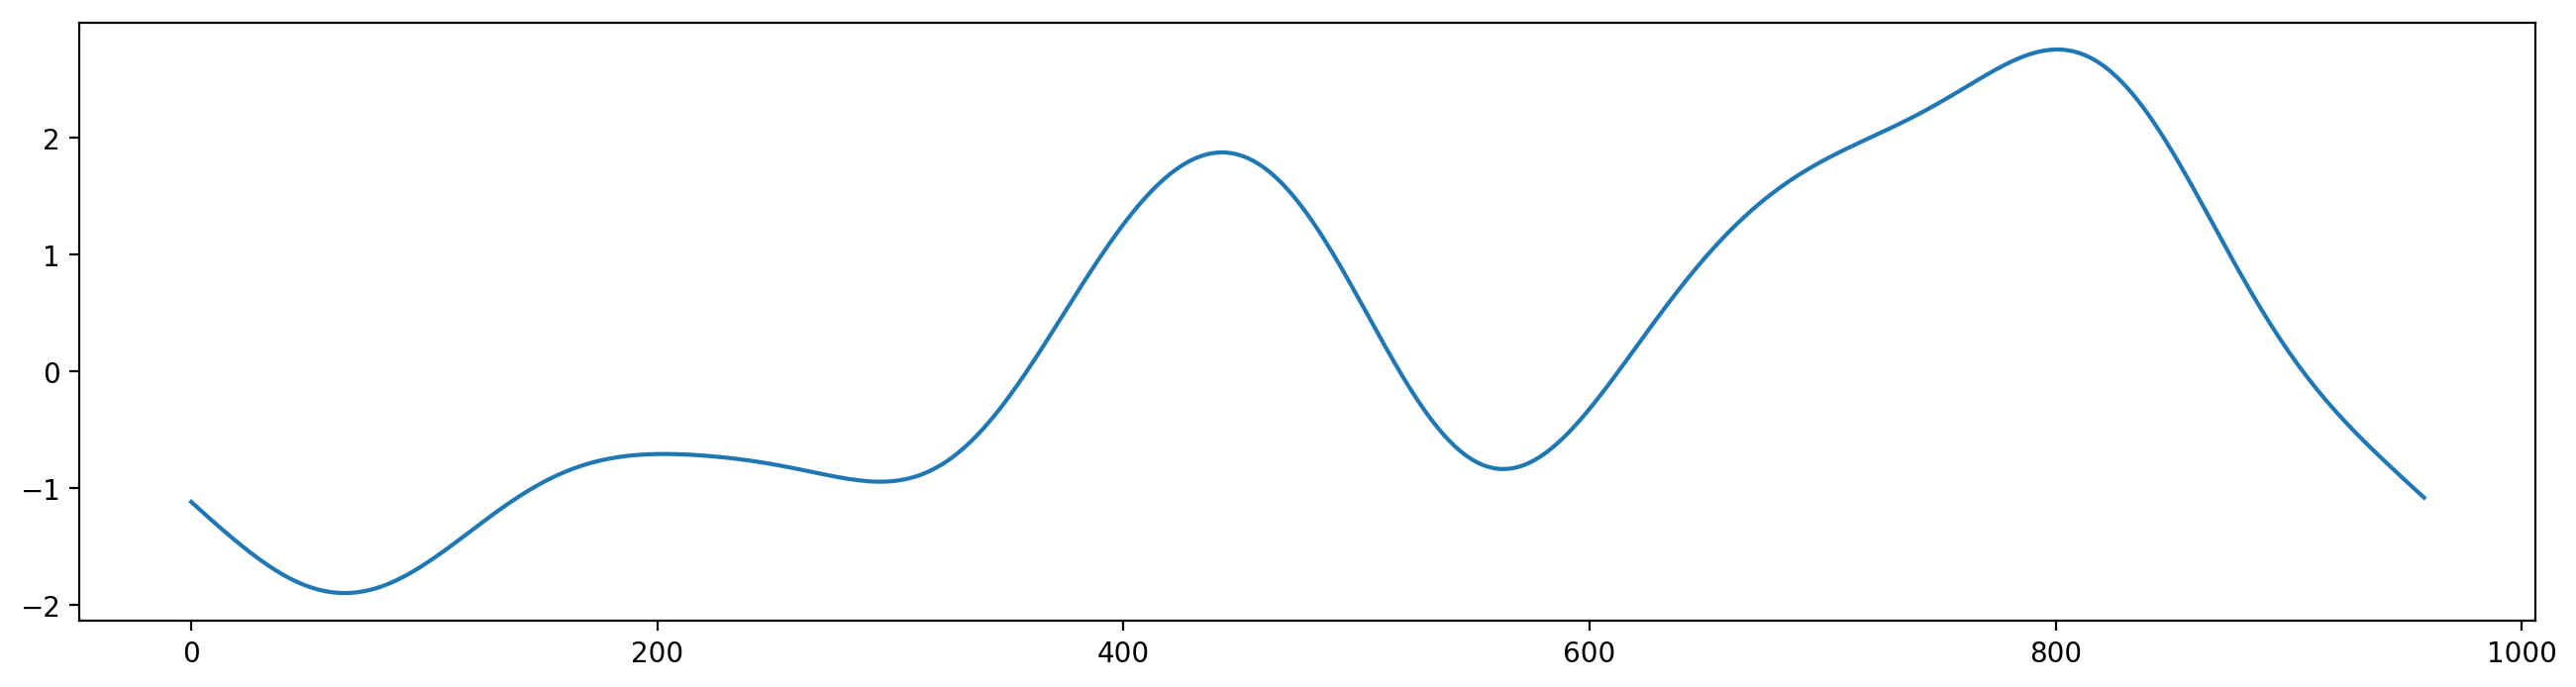

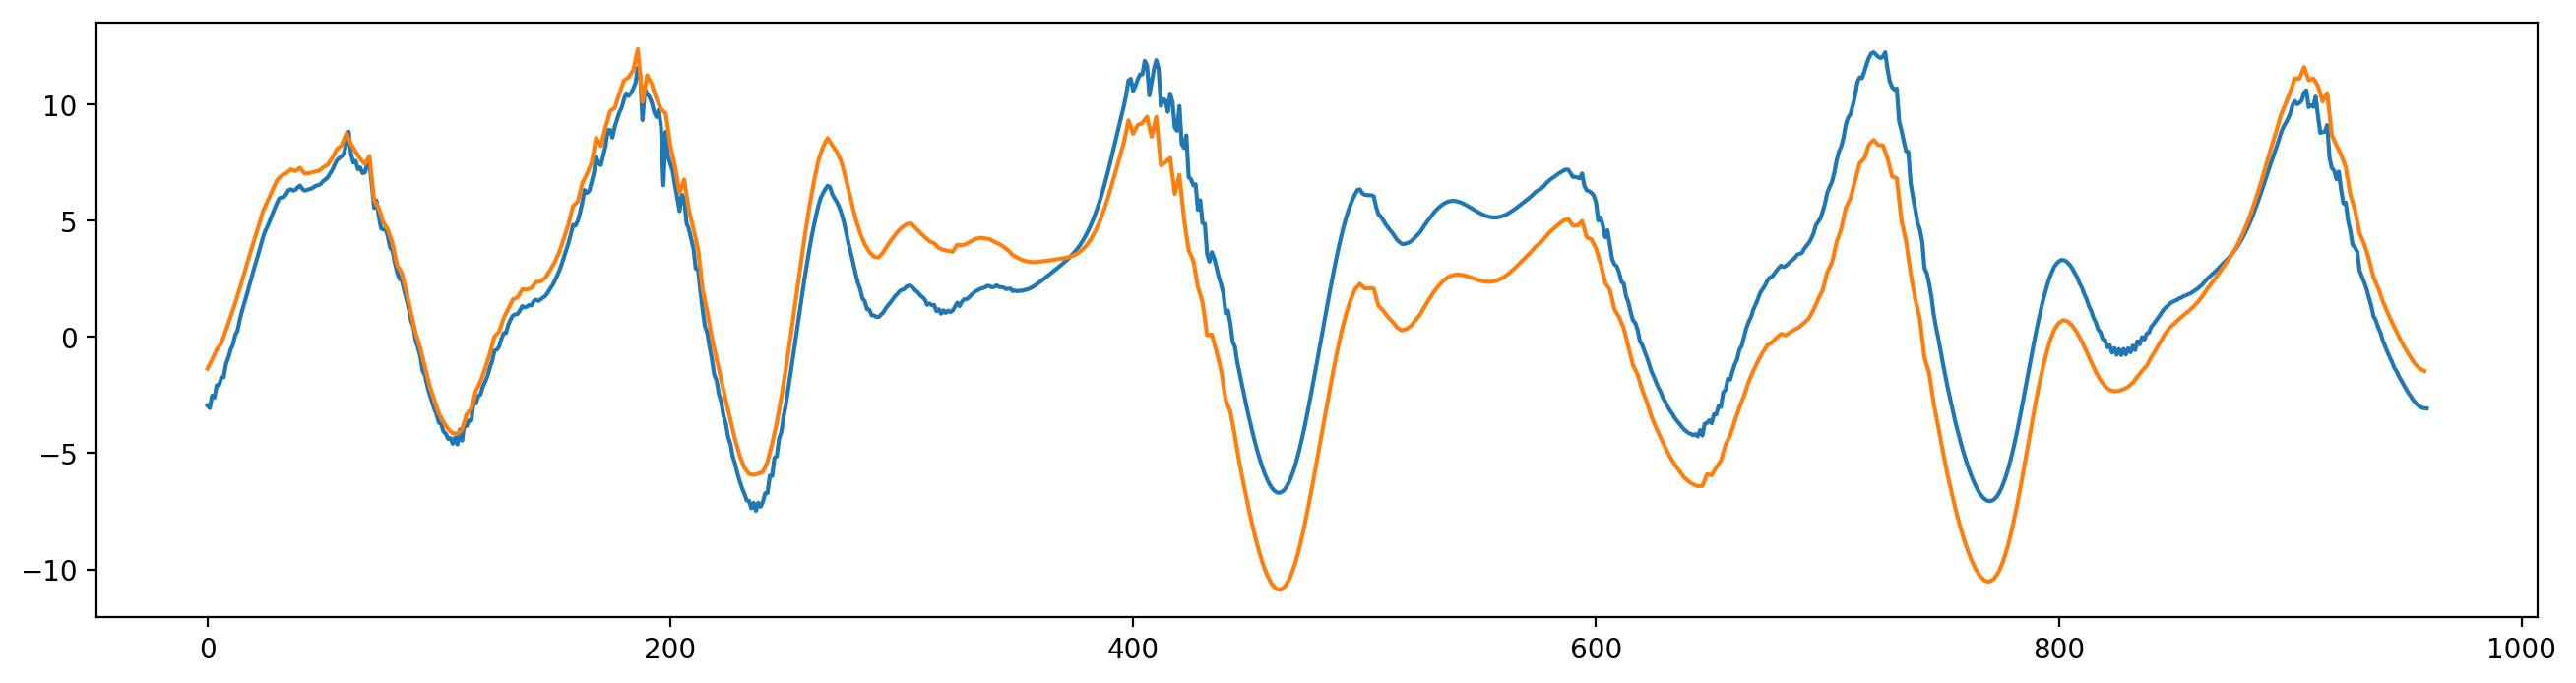

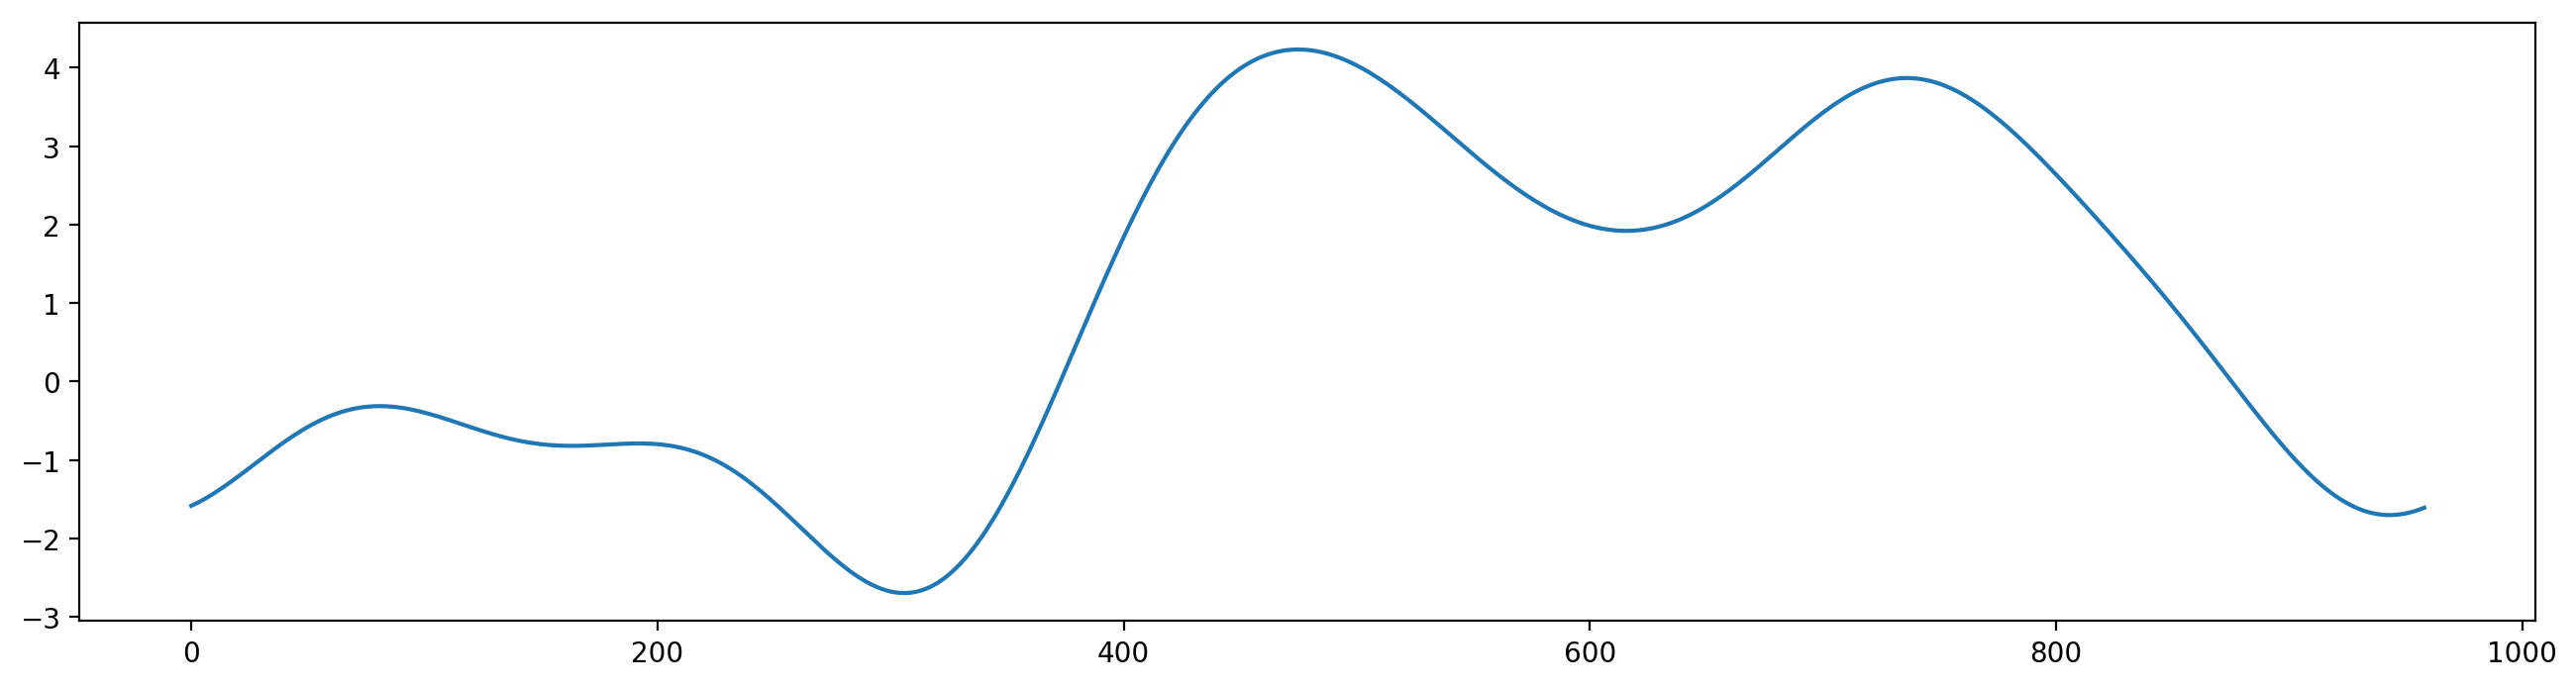

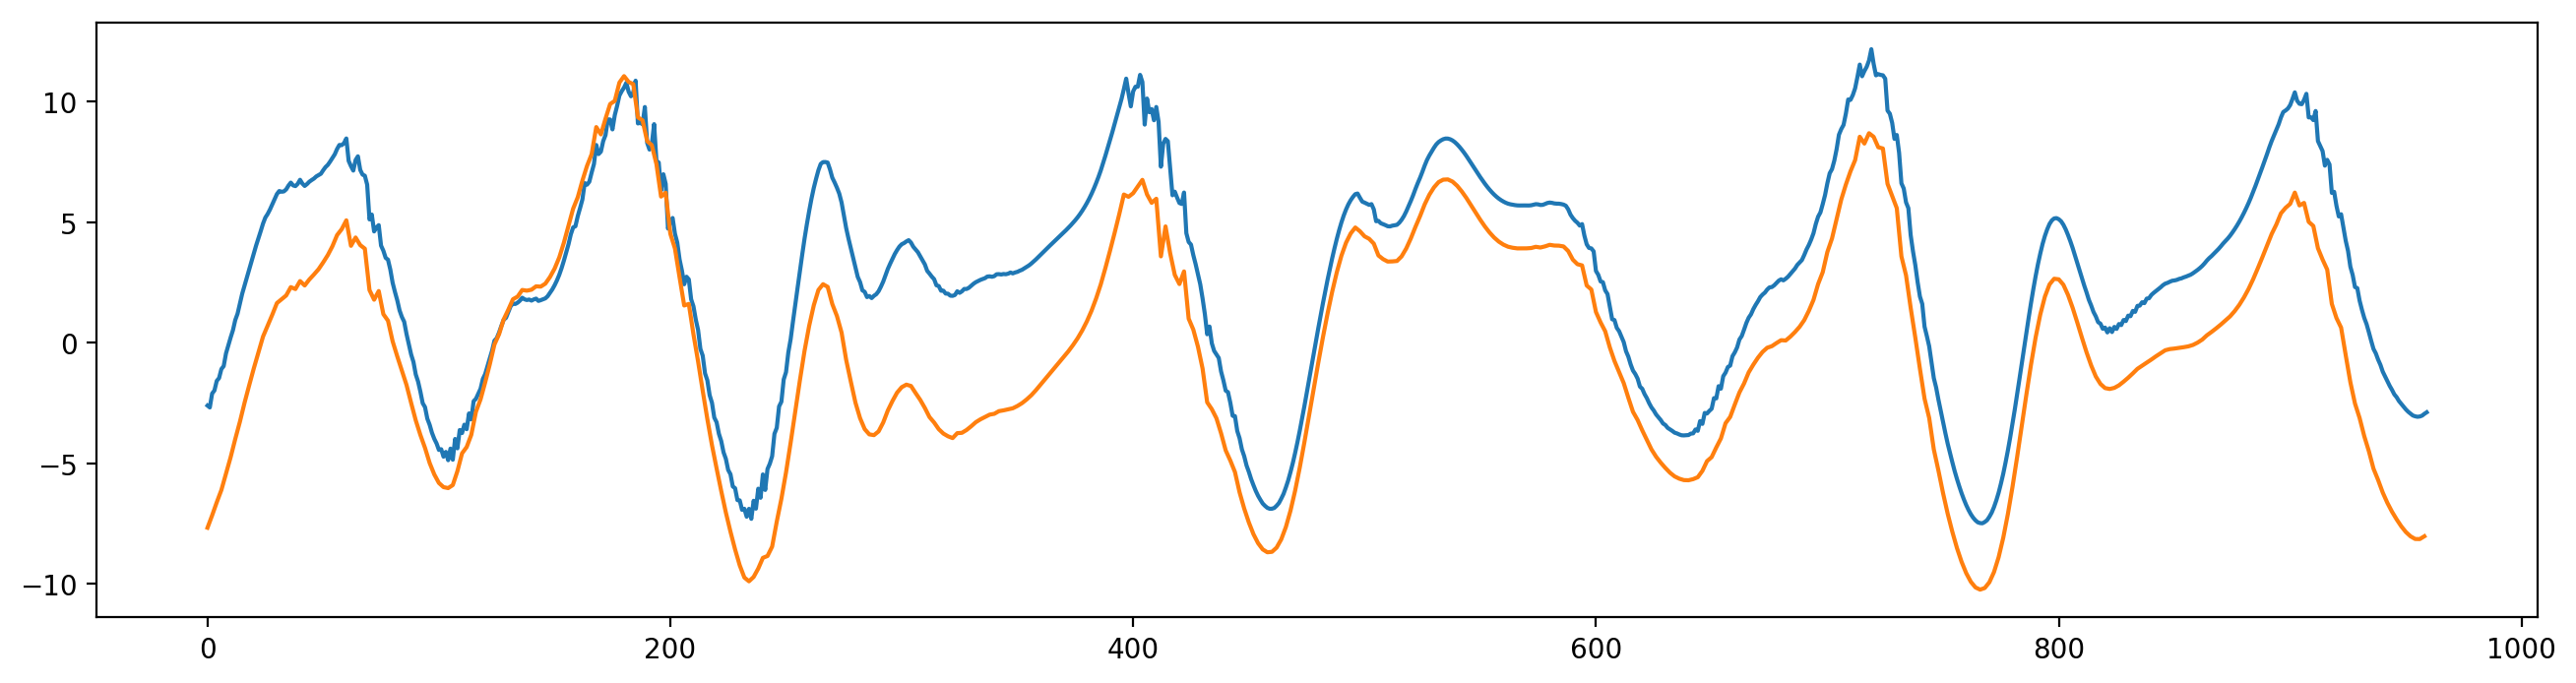

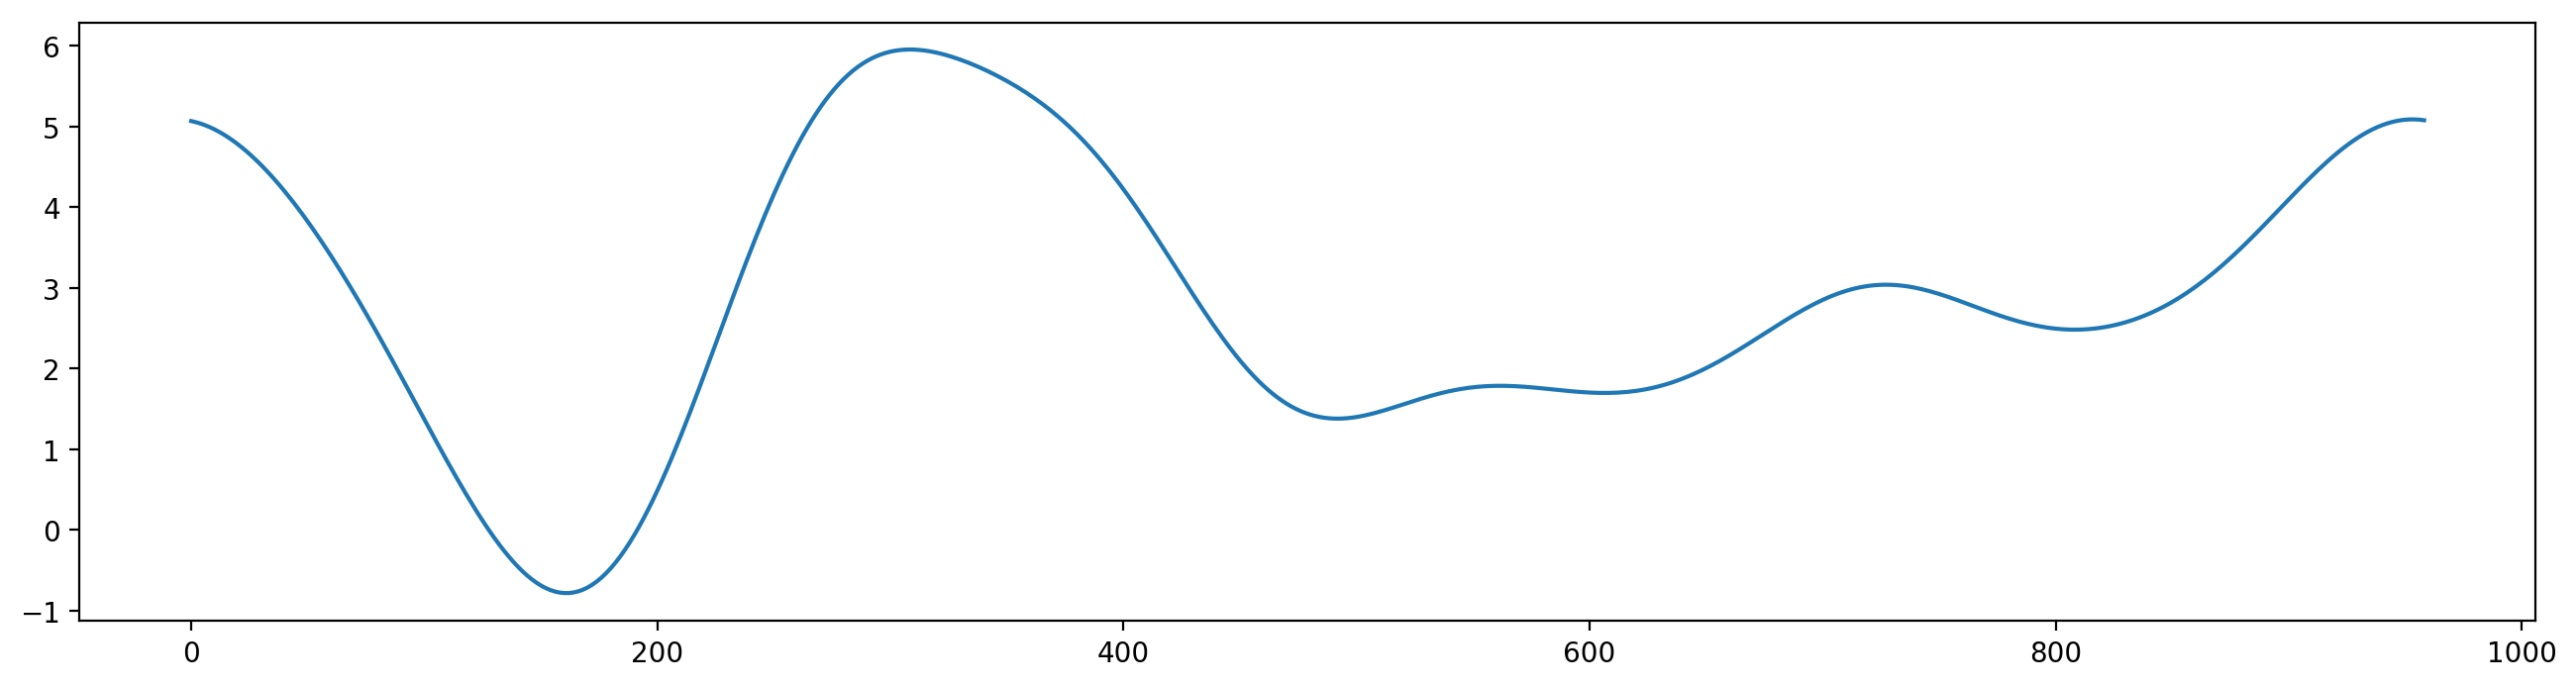

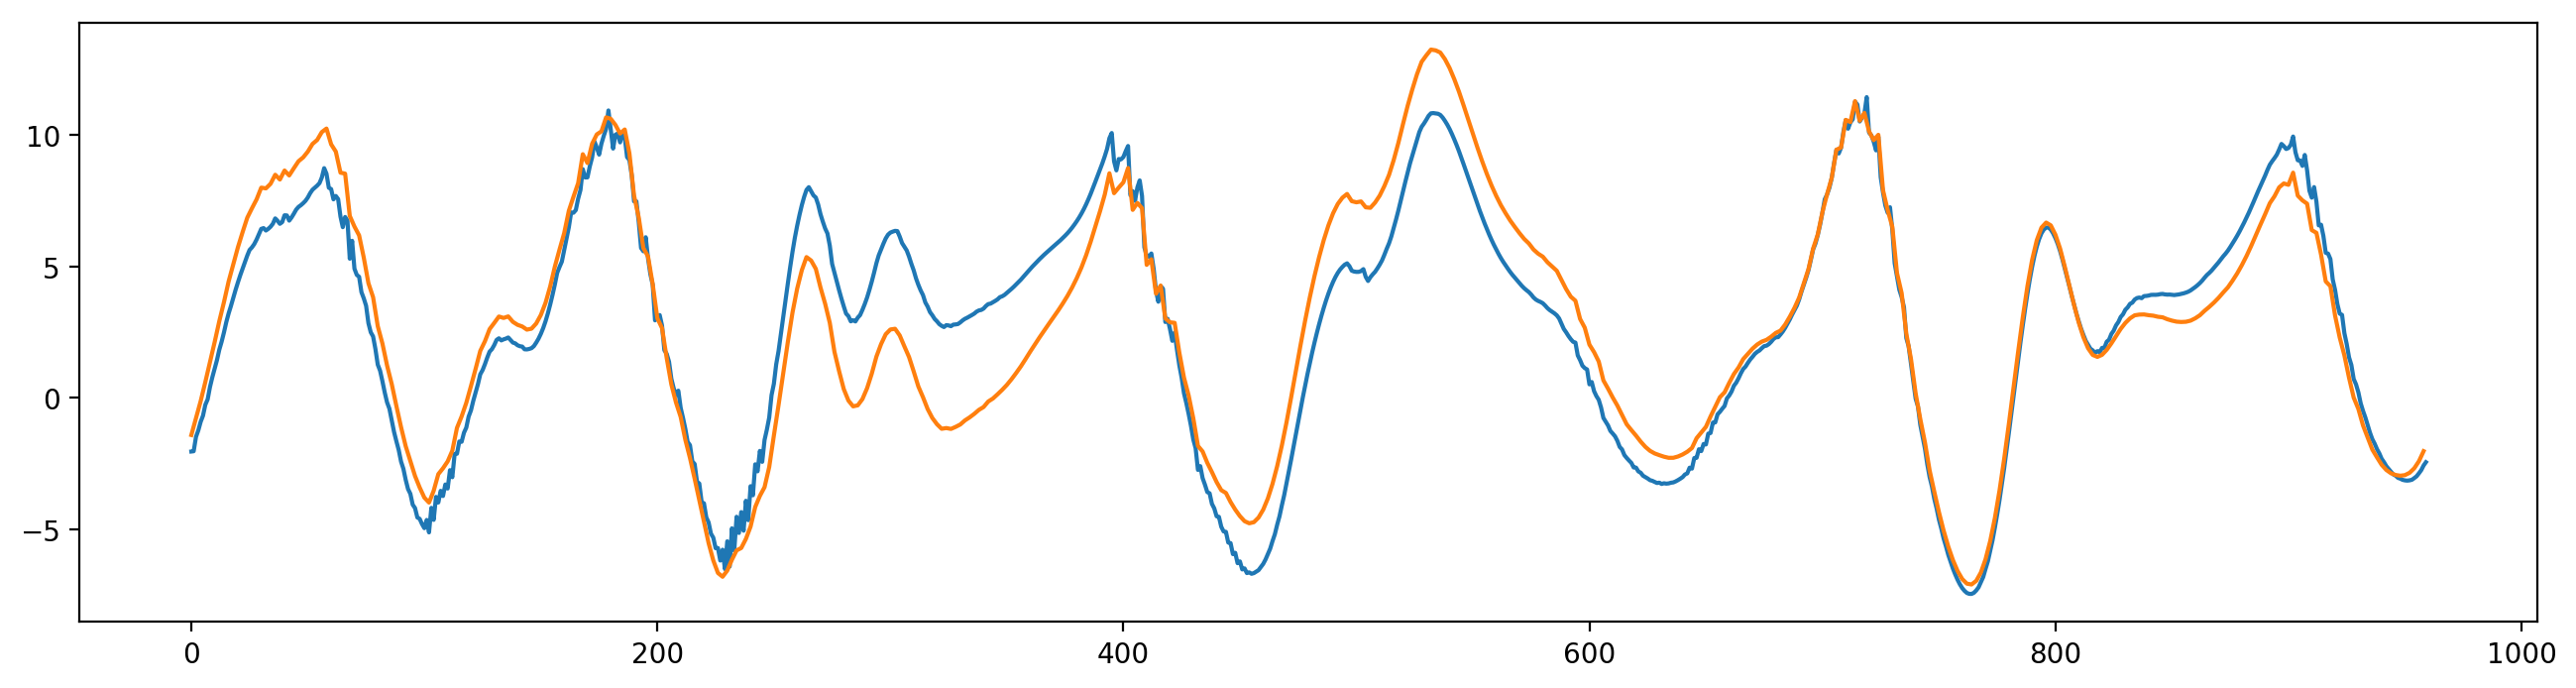

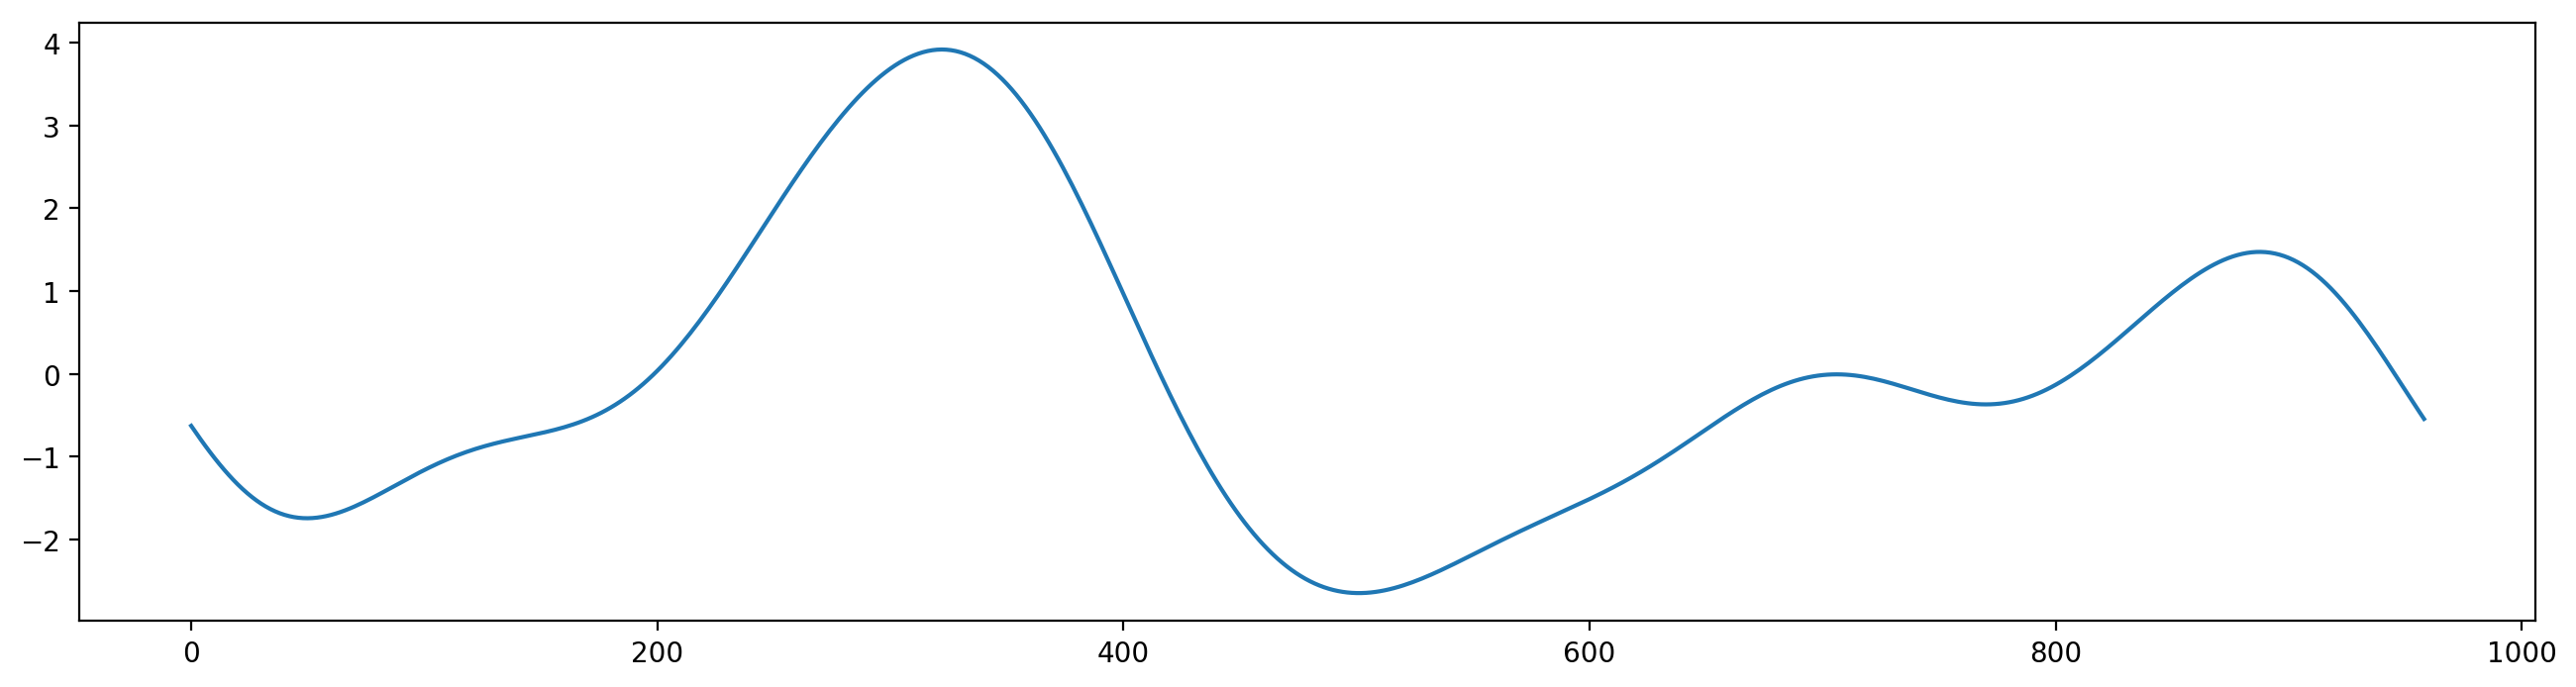

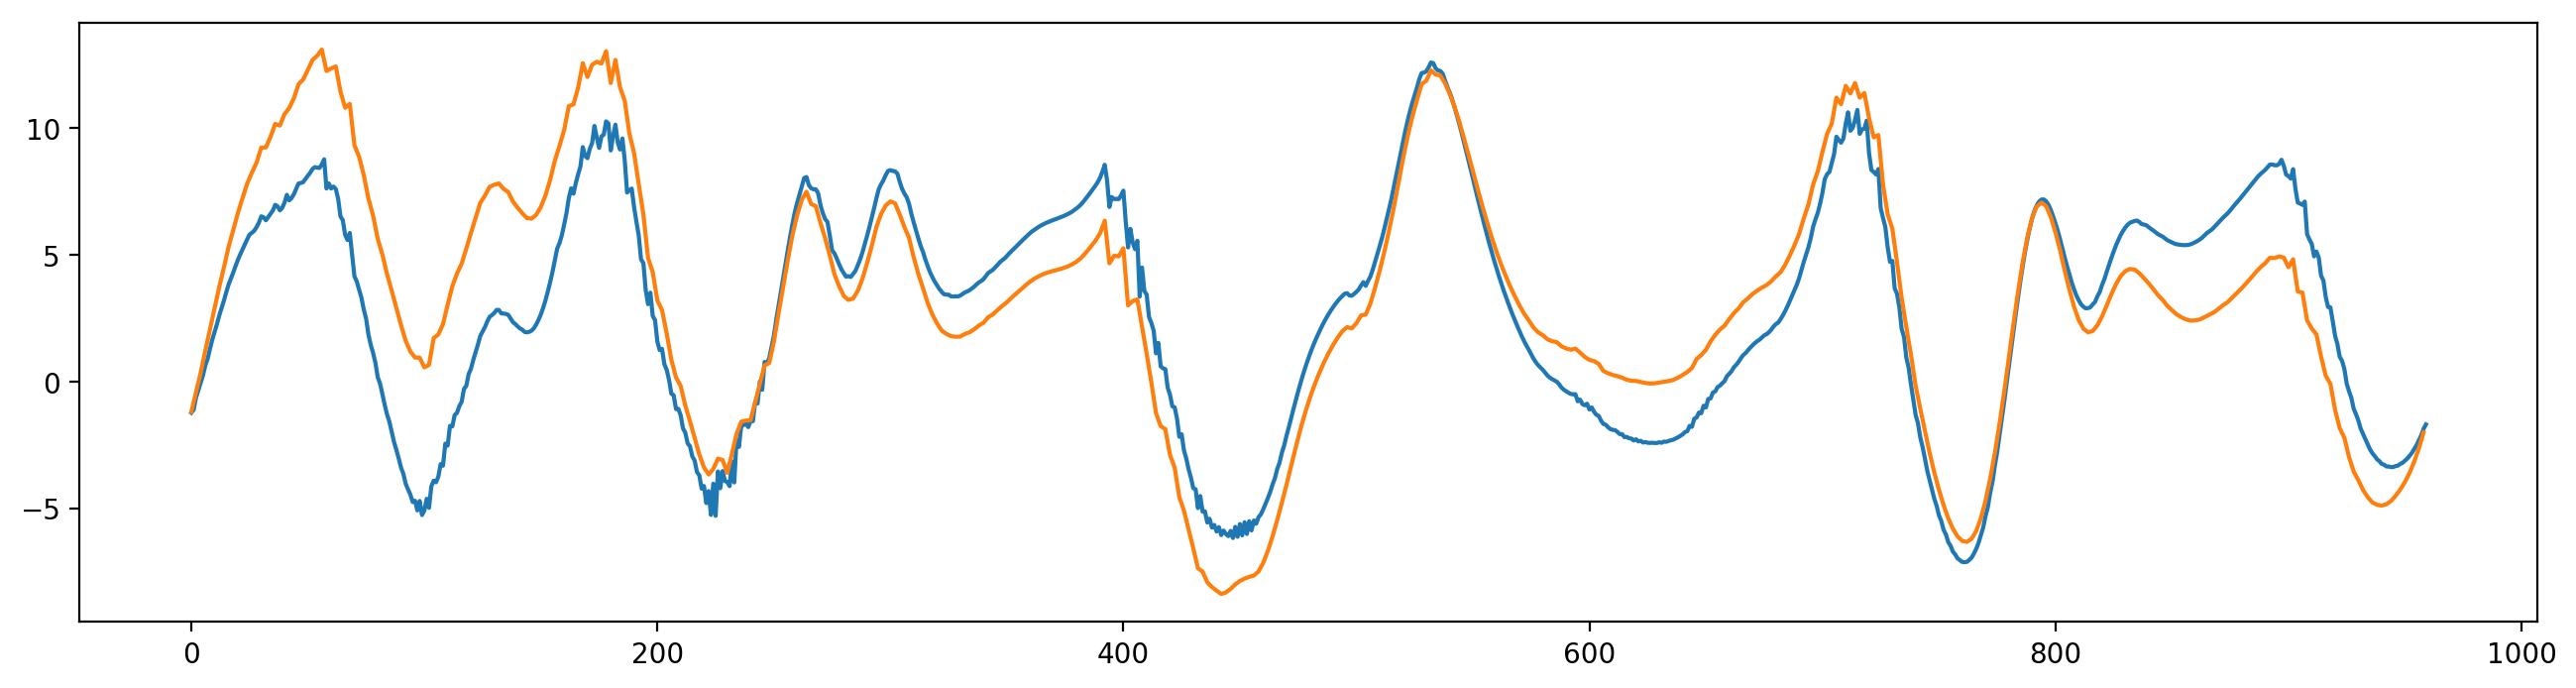

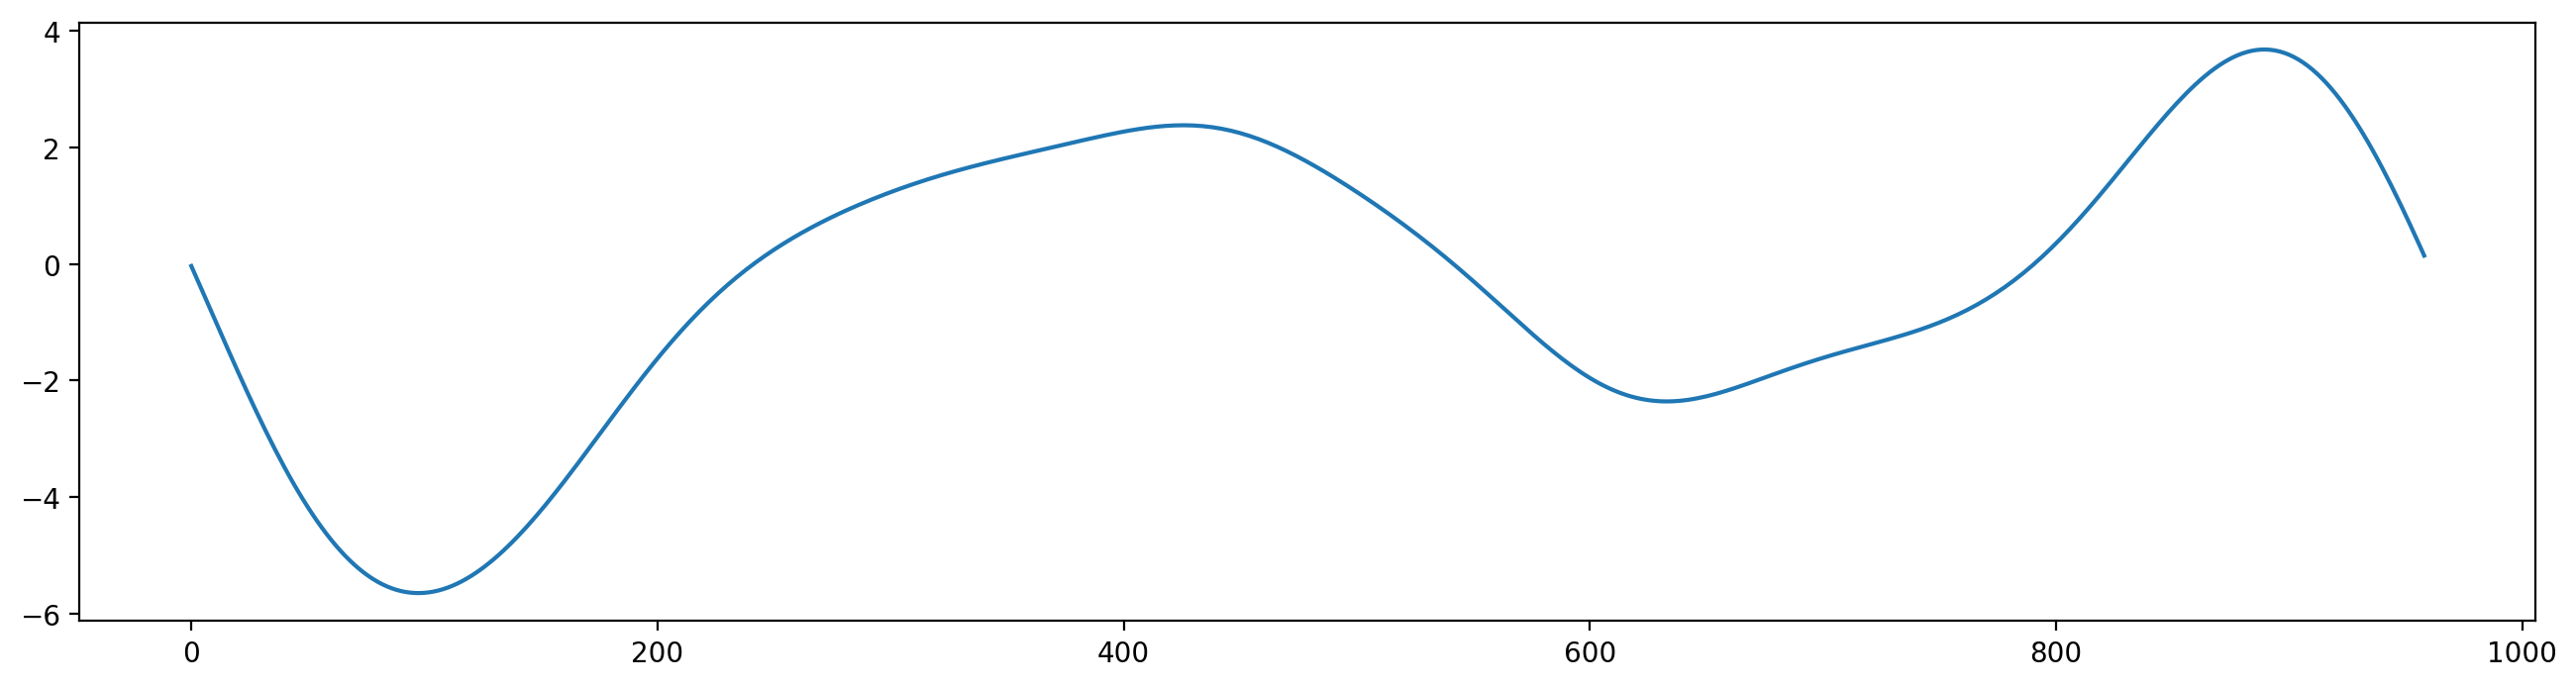

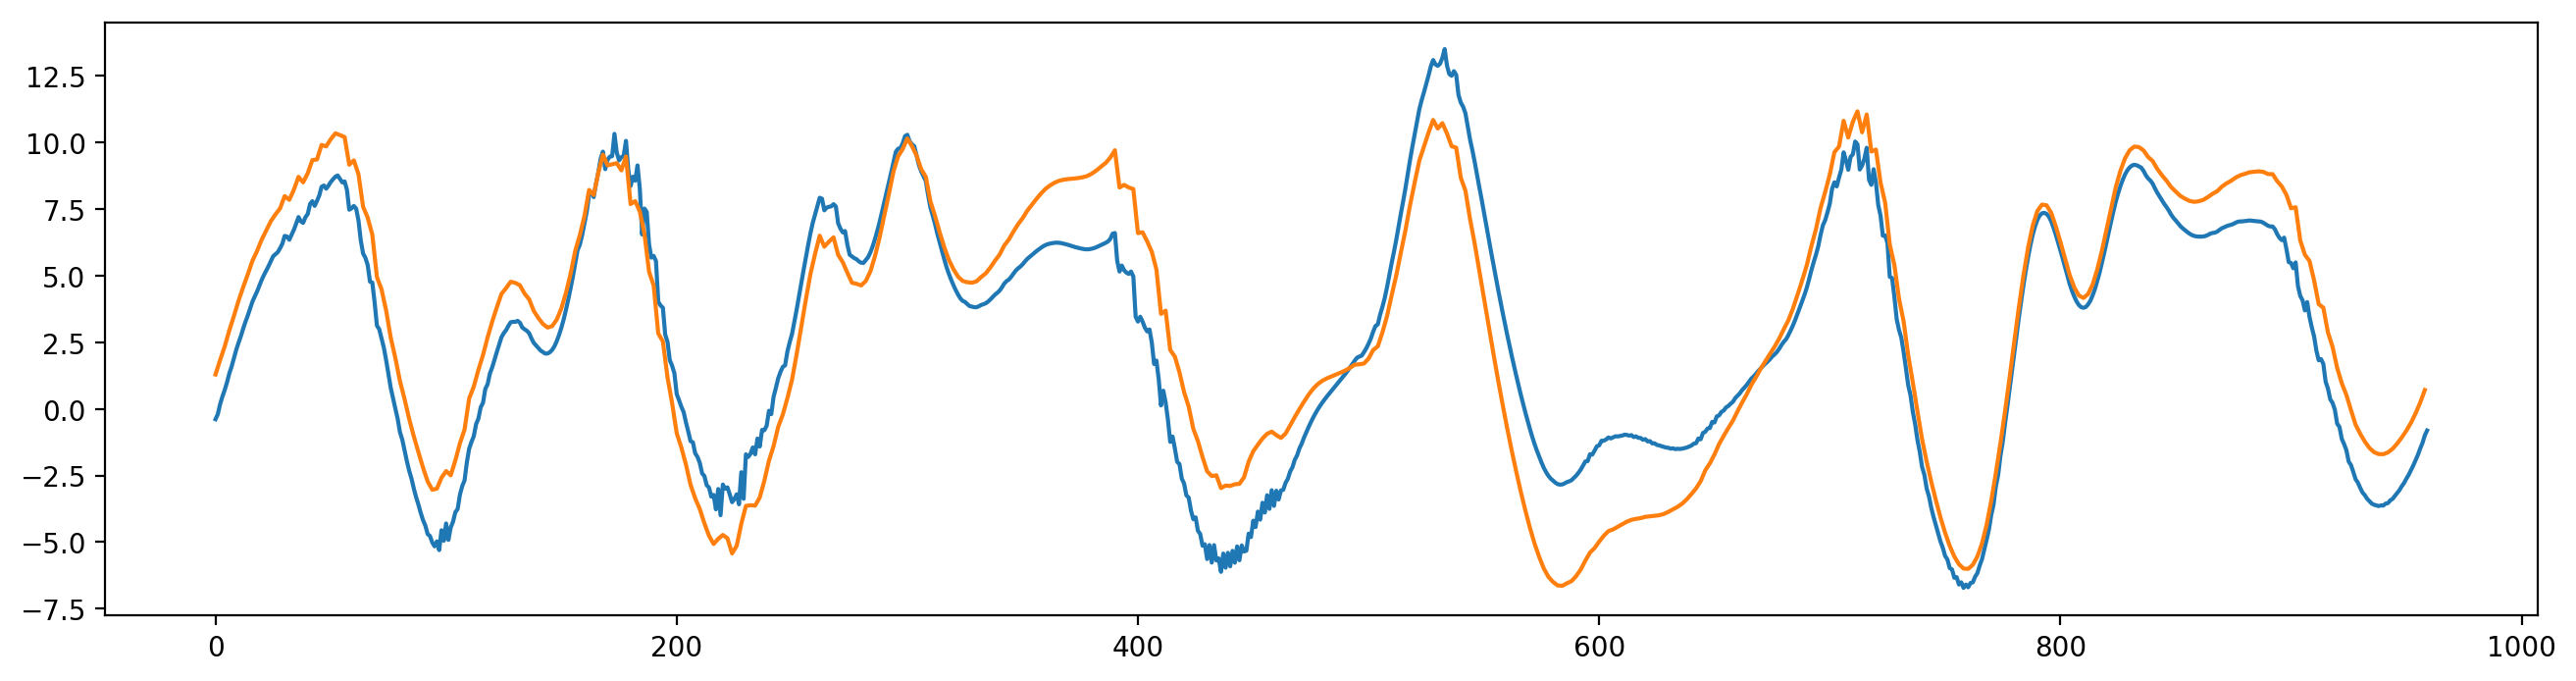

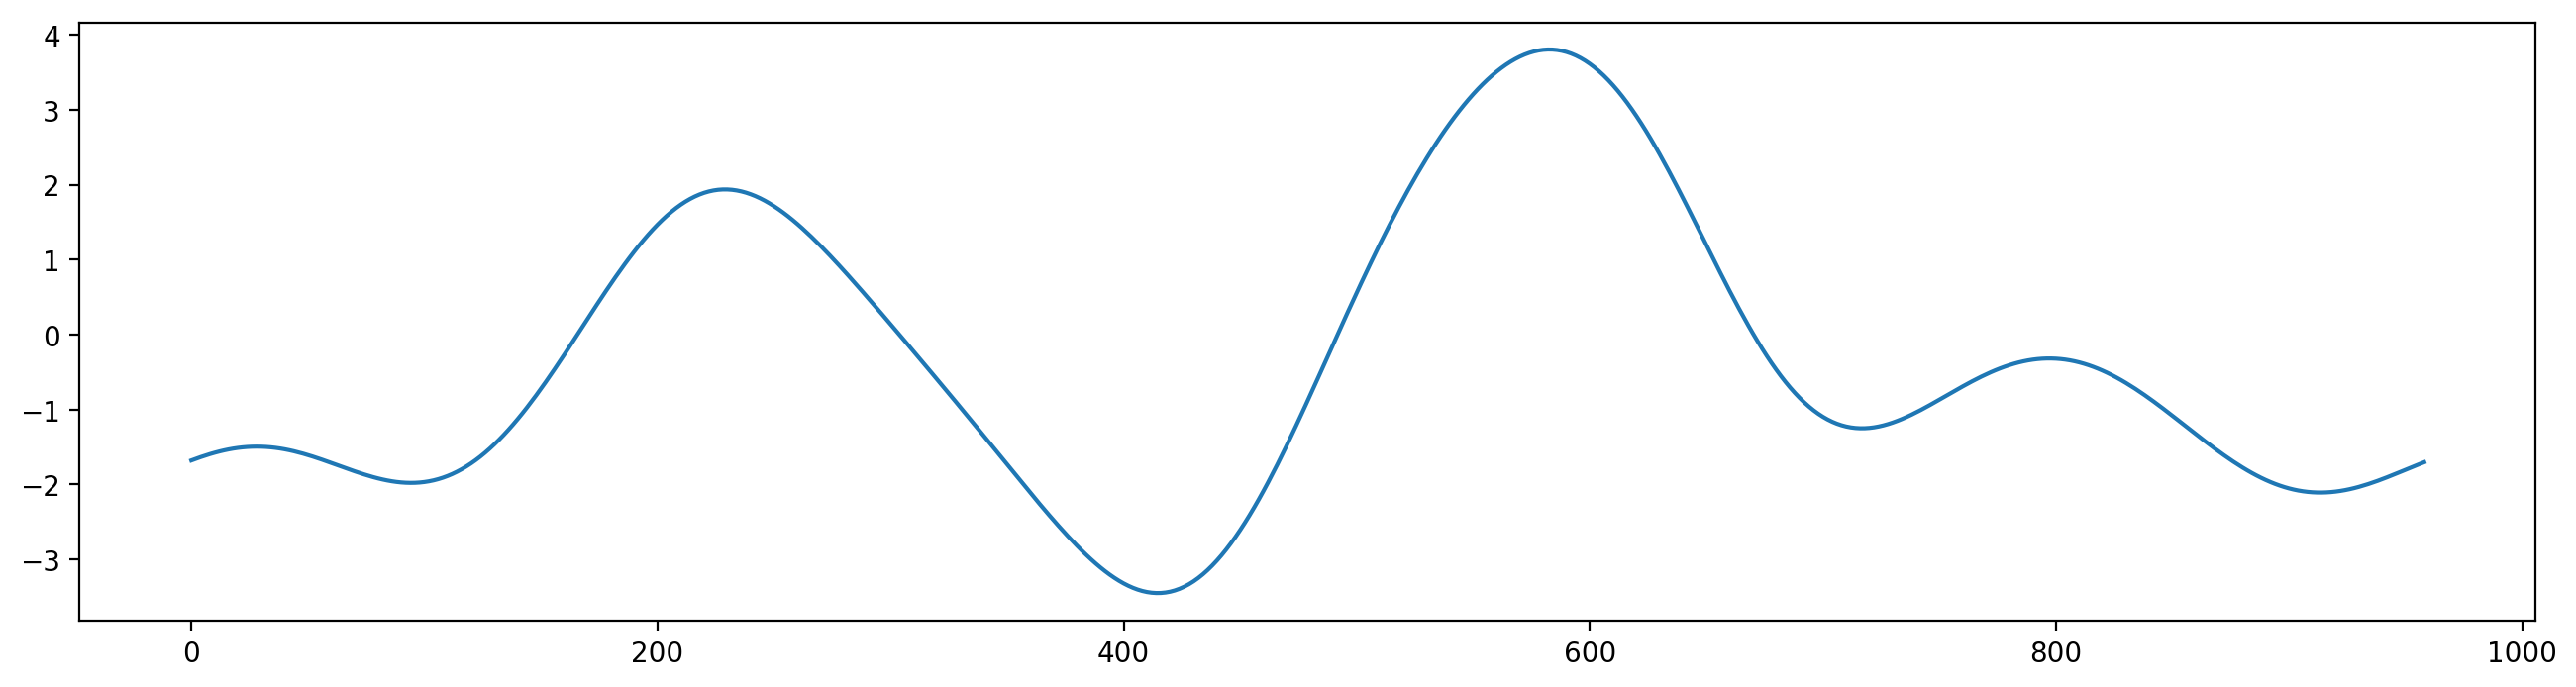

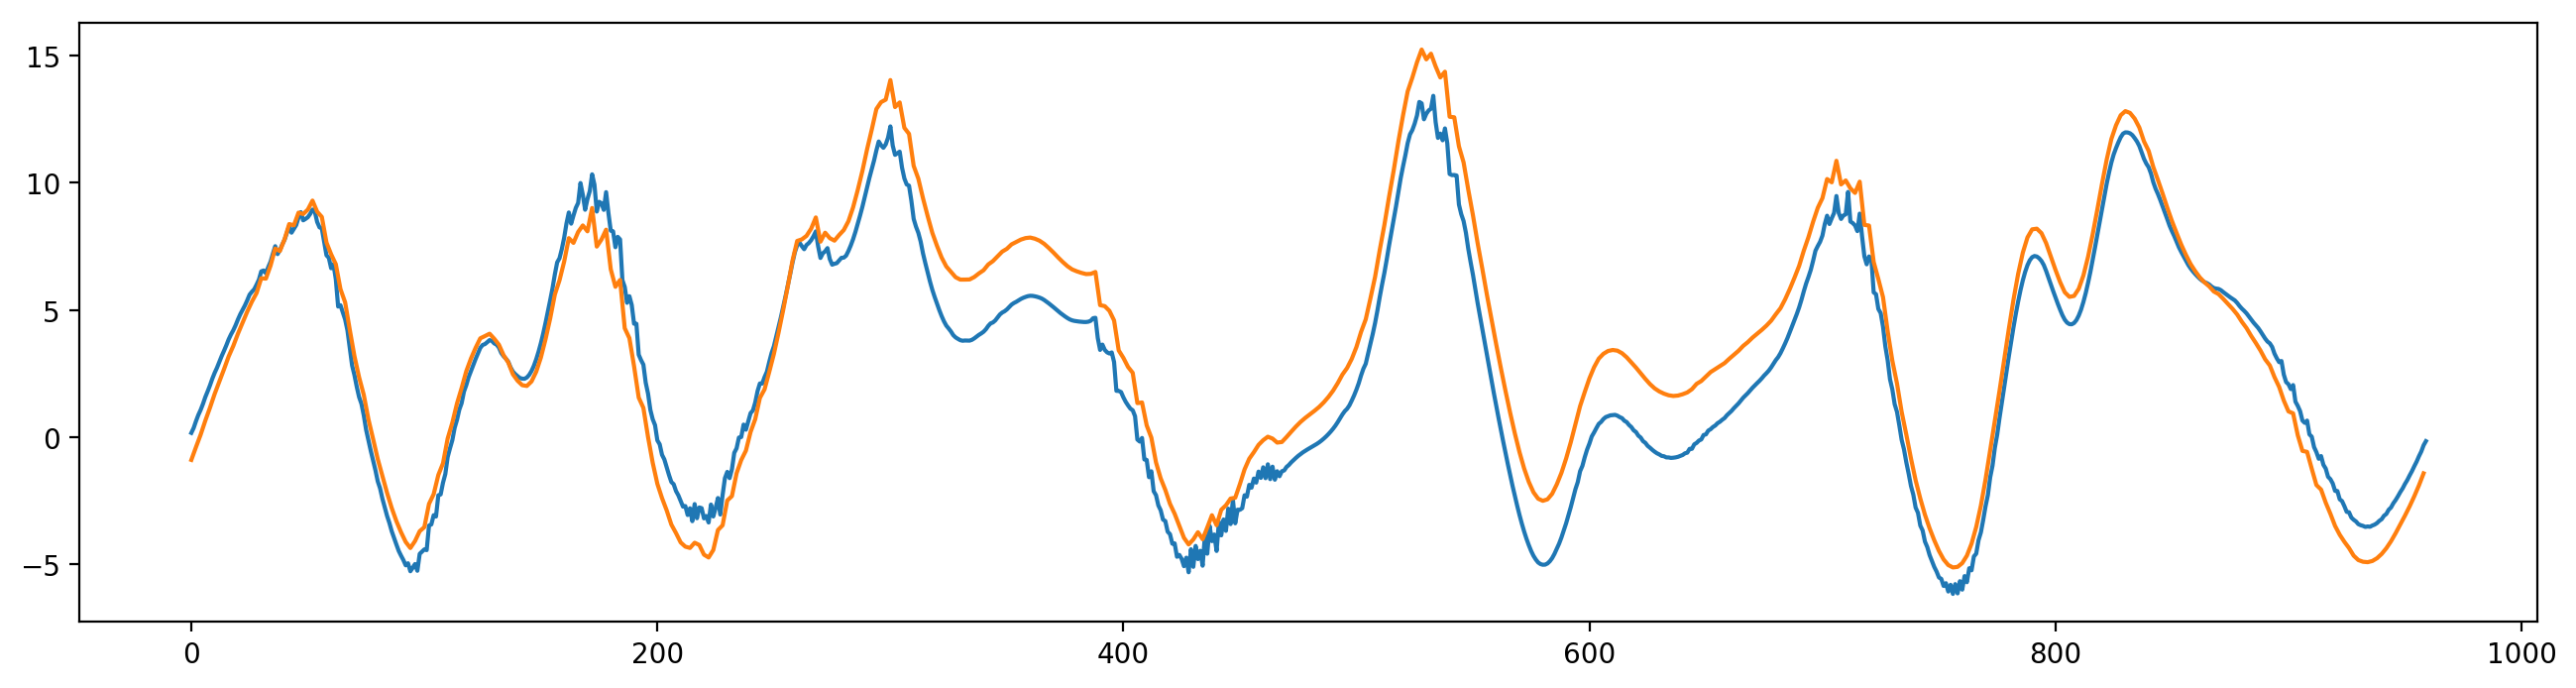

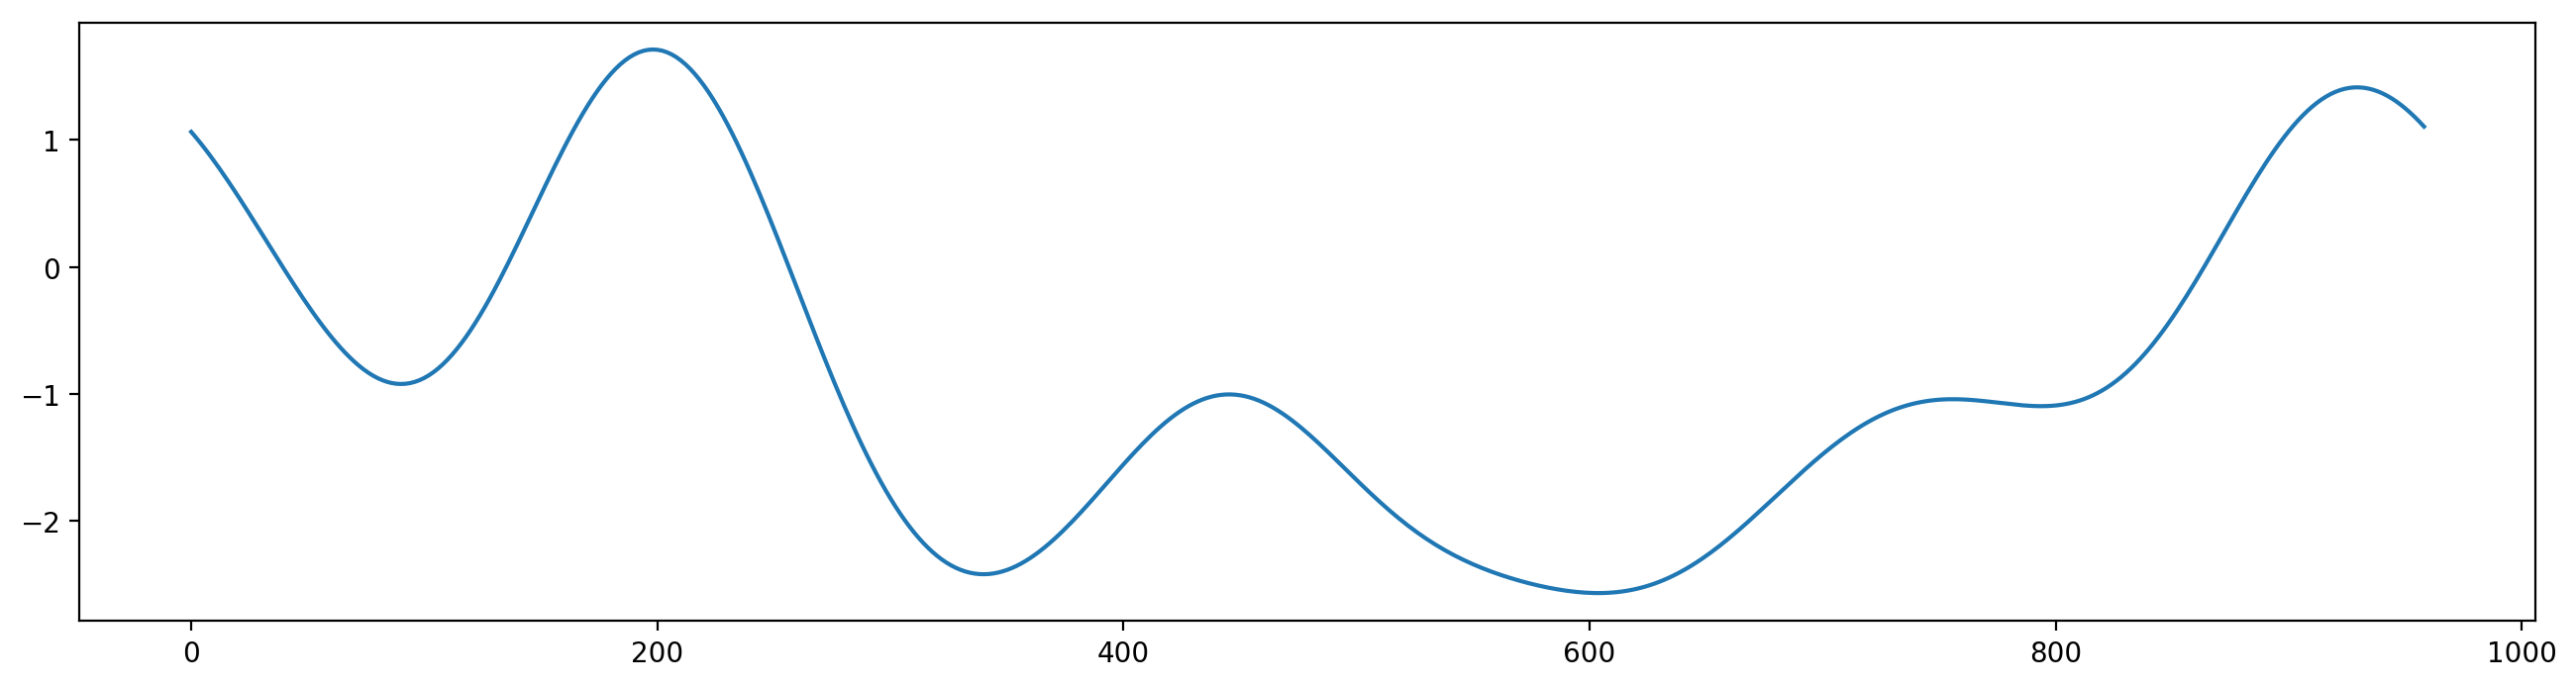

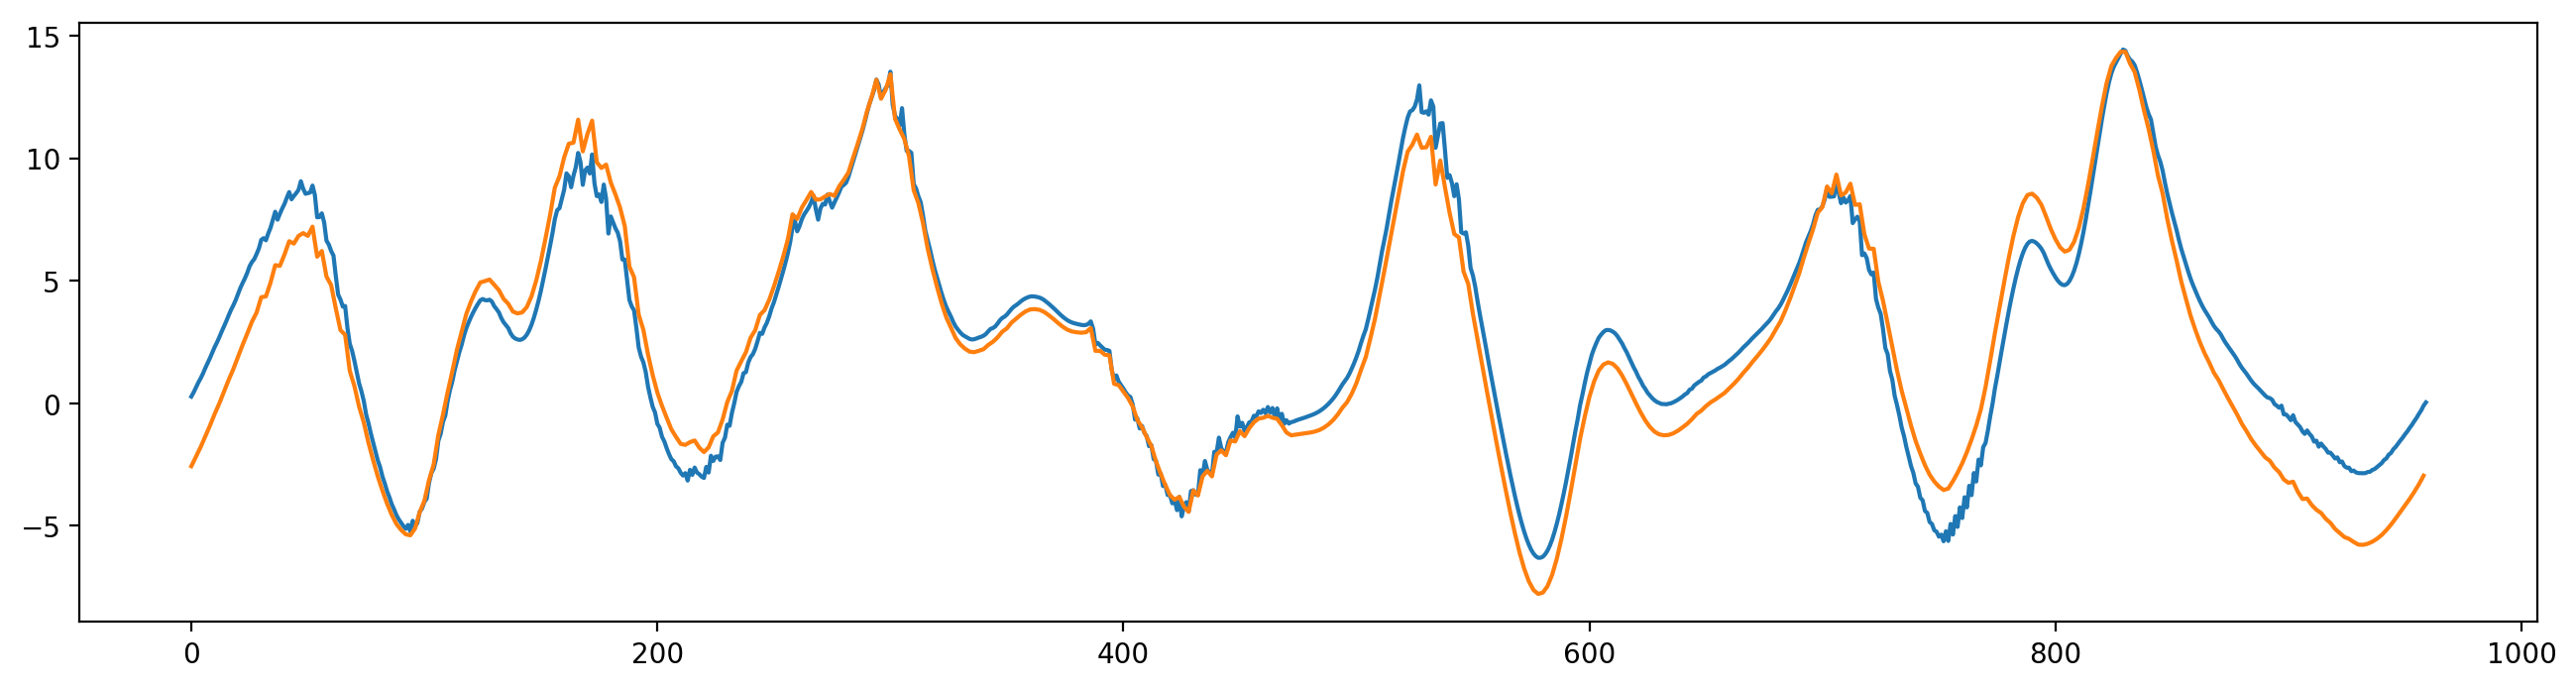

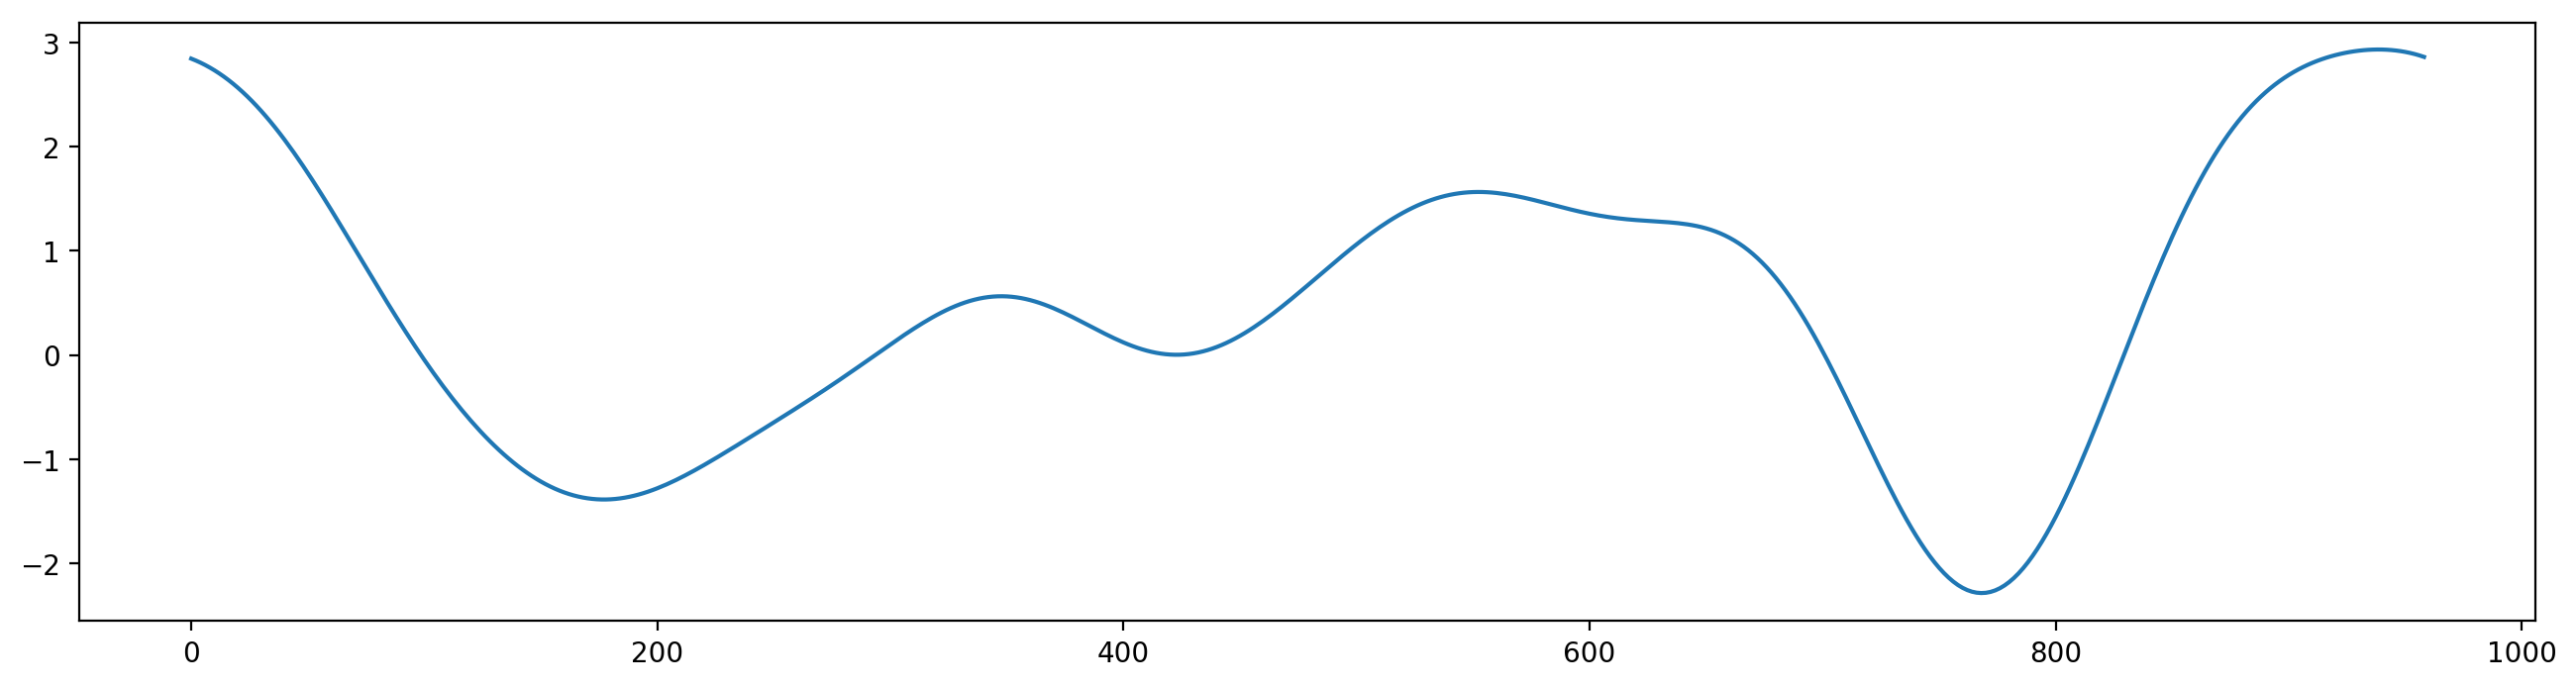

In [18]:
zzObs = np.arange(Nz)[::everyH]
figsize = plt.figaspect(1/4)
dpi=200
for ii in range(10):
    plt.figure(figsize=figsize, dpi=dpi)
    plt.plot(Zgt_ts.isel(time=ii))
#     plt.scatter(zzObs, Zobs_ts.isel(time=ii), s=5, c='r')
    plt.plot(zzObs, Zobs_ts.isel(time=ii))\
    
    this_err = (Zgt_ts.isel(time=ii).values[::everyH]
                - Zobs_ts.isel(time=ii).values)
    plt.figure(figsize=figsize, dpi=dpi)
    plt.plot(zzObs, this_err)

In [19]:
importlib.reload(assimilate)
importlib.reload(utilities)


rmse_array_f = np.ones([alpha_range.size, loc_range.size]) * np.nan
std_array_f = rmse_array_f.copy()

rmse_array_a = rmse_array_f.copy()
std_array_a = rmse_array_f.copy()

stdrd_dir = os.path.join(tune_dir, 'stdrd_loc')
if not os.path.exists(stdrd_dir):
    os.mkdir(stdrd_dir)
    
for alpha_count, this_alpha in enumerate(alpha_range):
    for loc_count, this_loc in enumerate(loc_range):
        this_folder_name = f'inf_{alpha_count:04}_loc_{loc_count:04}'
        this_dir_name = os.path.join(stdrd_dir, this_folder_name)
        if not os.path.exists(this_dir_name):
            os.mkdir(this_dir_name)
        print('alpha: ', this_alpha, '; loc: ', this_loc)
        print(this_dir_name)

        rho_Zc = np.arange(Nz)
        rho_Zc = np.minimum(np.abs(Nz - rho_Zc)%Nz, rho_Zc)
        rho_Zc = np.exp(-(rho_Zc**2)/(2*this_loc**2))
        rho_Zc = sp.linalg.circulant(rho_Zc)
#         imshow(rho_Zc)
        
        this_path = os.path.join(this_dir_name, 'rho0z')
        np.save(this_path, this_loc)
        
        this_path = os.path.join(this_dir_name, 'alpha')
        np.save(this_path, this_alpha)

        cycle_dict = {'Z0ens': Z0ens,
                      'Zobs_ts': Zobs_ts,
                      'Rz': Rz, 'Hz': Hz,
                      'Tkf': Tkf,
                      'dt_kf': dt_kf,
                      'dt_rk': dt_trial_rk,
                      'rho_Z': rho_Zc,
                      'rho0_Z': this_loc,
                      'alpha': this_alpha}
        try:
            returned_dict = assimilate.cycle_KF_LM3_stdrd(**cycle_dict)
            mu_f = returned_dict['mu_f']
            std_f = returned_dict['std_f']

            mu_a = returned_dict['mu_a']
            std_a = returned_dict['std_a']

            this_path = os.path.join(this_dir_name, 'mu_f.nc')
            mu_f.to_netcdf(this_path)

            this_path = os.path.join(this_dir_name, 'std_f.nc')
            std_f.to_netcdf(this_path)

            this_path = os.path.join(this_dir_name, 'mu_a.nc')
            mu_a.to_netcdf(this_path)

            this_path = os.path.join(this_dir_name, 'std_a.nc')
            std_a.to_netcdf(this_path)


            rmse_array_f[alpha_count, loc_count] = (np.sqrt(
                ((mu_f - Zgt_ts.sel(time=mu_f.time))**2).mean(axis=0))
                                          .isel(time=slice(Tspin_index, None)).mean())
            rmse_array_a[alpha_count, loc_count] = (np.sqrt(
                ((mu_a - Zgt_ts.sel(time=mu_f.time))**2).mean(axis=0))
                                          .isel(time=slice(Tspin_index, None)).mean())
            std_array_f[alpha_count, loc_count] = (np.sqrt((std_f**2).mean(axis=0))
                                                  .isel(time=slice(Tspin_index, None)).mean())
            std_array_a[alpha_count, loc_count] = (np.sqrt((std_a**2).mean(axis=0))
                                                  .isel(time=slice(Tspin_index, None)).mean())
            print('rmse_f: ', rmse_array_f[alpha_count, loc_count])
            print('rmse_a: ', rmse_array_a[alpha_count, loc_count])
        except:
            print(this_dir_name, ' has failed.')

alpha:  0.0 ; loc:  1.0
/home/travisharty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/stdrd_loc/inf_0000_loc_0000
rmse_f:  3.9844166019254756
rmse_a:  3.7879531954730914
alpha:  0.0 ; loc:  2.0
/home/travisharty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/stdrd_loc/inf_0000_loc_0001
rmse_f:  4.762667991569342
rmse_a:  4.675790102445106
alpha:  0.0 ; loc:  3.0
/home/travisharty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/stdrd_loc/inf_0000_loc_0002


/home/travisharty/Documents/python_code/multi_loc/multi_loc/utilities.py:370: RuntimeWarning: overflow encountered in multiply
  T1 = -1 * np.roll(W, 2 * K, axis=0) * np.roll(W, K, axis=0)
/home/travisharty/Documents/python_code/multi_loc/multi_loc/utilities.py:371: RuntimeWarning: overflow encountered in multiply
  WX = np.roll(W, K, axis=0) * np.roll(X, -K, axis=0)
/home/travisharty/Documents/python_code/multi_loc/multi_loc/utilities.py:373: RuntimeWarning: invalid value encountered in add
  return T1 + T2
/home/travisharty/Documents/python_code/multi_loc/multi_loc/utilities.py:356: RuntimeWarning: overflow encountered in multiply
  T1 = -1 * np.roll(X, 2, axis=0) * np.roll(X, 1, axis=0)
/home/travisharty/Documents/python_code/multi_loc/multi_loc/utilities.py:357: RuntimeWarning: overflow encountered in multiply
  T2 = np.roll(X, 1, axis=0) * np.roll(X, -1, axis=0)
/home/travisharty/Documents/python_code/multi_loc/multi_loc/utilities.py:358: RuntimeWarning: invalid value encountered 

/home/travisharty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/stdrd_loc/inf_0000_loc_0002  has failed.
alpha:  0.0 ; loc:  4.0
/home/travisharty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/stdrd_loc/inf_0000_loc_0003


/home/travisharty/Documents/python_code/multi_loc/multi_loc/utilities.py:358: RuntimeWarning: overflow encountered in add
  return T1 + T2
/home/travisharty/Documents/python_code/multi_loc/multi_loc/utilities.py:348: RuntimeWarning: overflow encountered in add
  return T1 + T2
/home/travisharty/Documents/python_code/multi_loc/multi_loc/utilities.py:299: RuntimeWarning: invalid value encountered in subtract
  Y = Z - X


/home/travisharty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/stdrd_loc/inf_0000_loc_0003  has failed.
alpha:  0.0 ; loc:  5.0
/home/travisharty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/stdrd_loc/inf_0000_loc_0004


/home/travisharty/Documents/python_code/multi_loc/multi_loc/utilities.py:305: RuntimeWarning: invalid value encountered in add
  dZdt = T1 + T2 + T3 - X - b*Y + F


/home/travisharty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/stdrd_loc/inf_0000_loc_0004  has failed.
alpha:  0.0 ; loc:  6.0
/home/travisharty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/stdrd_loc/inf_0000_loc_0005
/home/travisharty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/stdrd_loc/inf_0000_loc_0005  has failed.
alpha:  0.04 ; loc:  1.0
/home/travisharty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/stdrd_loc/inf_0001_loc_0000
rmse_f:  2.496992239452776
rmse_a:  2.3051273758981745
alpha:  0.04 ; loc:  2.0
/home/travisharty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/stdrd_loc/inf_0001_loc_0001


/home/travisharty/Documents/python_code/multi_loc/multi_loc/utilities.py:305: RuntimeWarning: overflow encountered in add
  dZdt = T1 + T2 + T3 - X - b*Y + F


/home/travisharty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/stdrd_loc/inf_0001_loc_0001  has failed.
alpha:  0.04 ; loc:  3.0
/home/travisharty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/stdrd_loc/inf_0001_loc_0002
/home/travisharty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/stdrd_loc/inf_0001_loc_0002  has failed.
alpha:  0.04 ; loc:  4.0
/home/travisharty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/stdrd_loc/inf_0001_loc_0003
/home/travisharty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/stdrd_loc/inf_0001_loc_0003  has failed.
alpha:  0.04 ; loc:  5.0
/home/travisharty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/stdrd_loc/inf_0001_loc_0004
/home/travisharty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/stdrd_loc/inf_0001_loc_0004  has failed.
alpha:  0.04 ; loc:  6.0
/home/travisharty/Documents/python_code/multi_loc/notebooks/RK_tune/coarse_obs_R/stdr

In [20]:
this_path = os.path.join(stdrd_dir, 'rmse_array_f.npy')
np.save(this_path, rmse_array_f)

this_path = os.path.join(stdrd_dir, 'std_array_f.npy')
np.save(this_path, std_array_f)

this_path = os.path.join(stdrd_dir, 'rmse_array_a.npy')
np.save(this_path, rmse_array_a)

this_path = os.path.join(stdrd_dir, 'std_array_a.npy')
np.save(this_path, std_array_a)